# Importing modules

In [1]:
# Cleanning
import pandas as pd
import numpy as np
from scipy.stats import mode


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import iqr
from scipy.stats import scoreatpercentile as pct
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

# Functions

## Data Cleaning Pipeline Functions

### Importing Data

In [2]:
# Function Wrapping the loading operation - For Pipeline Control

def load_data():

    file1 = pd.read_csv("Data/file1.csv")
    file2 = pd.read_csv("Data/file2.csv")
    file3 = pd.read_csv("Data/file3.csv")

    file3.rename(columns={"State":"ST", "Gender": "GENDER"}, inplace=True)

    return pd.concat([file1,file2,file3]).reset_index(drop=True)
    


### Standardizing Headings

In [3]:
def standard_headings(df):
    """
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"
    
    Parameters
    ----------
    columns_list : Pandas Dataframe

    Returns
    -------
    Returns a Pandas Dataframe with an standarized heading, i.e lower case and " " replaced by "_"

    """  
    heading = df.columns
    df.columns = [clabel.lower().replace(" ", "_") for clabel in heading]
    return df


### Correcting data types

In [4]:
# Function Wrapping the two data correction type operations - For Pipeline Control

def dt_corrector(df):
    
    df.customer_lifetime_value = df.customer_lifetime_value.apply(lambda x: np.round(float(x.strip("%"))*100) if type(x)==str else np.round(x) if x==x else x)
    df.number_of_open_complaints = df.number_of_open_complaints.apply(lambda x: np.array(x.split("/"), dtype=int)[1] if type(x)==str else x)

    return df

### Bucketing Data

In [5]:

def bucket_series(df, columns_list, bucketing_dict):
    """
    Returns a Pandas Dataframe with the columns contained in columns_list modified to only have unique labels. The reduction is done following the logic contained in cleaning_dict.
    
    Parameters
    ----------
    df : Pandas Dataframe
        The data frame to be cleaned
    columns_list : List
        A list of strings with the labels of the target columns
    cleaning_dict : Dictionary
        A dictionary of the form {redundant_value : unique_value}

    Returns
    -------

    Returns a Pandas Dataframe with the columns contained in columns_list modified to only have unique labels. The reduction is done following the logic contained in cleaning_dict.

    """
    for column in columns_list:

        df[column] = list(map(lambda item : bucketing_dict[item] if item in bucketing_dict.keys() else item, df[column]))

    return df


### Removing Duplicates

### Replacing Null values (Numeric Variables)

In [6]:
def replace_by(df, columns_list, replace_zeros = False, replacer = np.mean):
    """
    Returns a Pandas Dataframe with the target columns nan values replaced by the column selected paramete (median or mean).
    
    Parameters
    ----------
    df : Pandas dataframe
        The data frame to be cleaned
    columns_list : List
        A list of strings with the labels of the target columns

    parameter : String
        Parameter to be used for the replacement
        "mean" for the mean (default)
        "median" for the median

    Returns
    -------
    Returns a Pandas Dataframe with the target columns nan values replaced by the column selected paramete (median or mean).

    """
    for column in columns_list:

        if replace_zeros == True:

            target = df[column][df[column] > 0]
            df[column] = list(map(lambda x: replacer(target) if x == 0 else replacer(target) if x!=x else x, df[column]))

        elif replace_zeros == False:

            target = df[column]
            df[column] = df[column].fillna(replacer(target))

    return df



### Replacing Null values (Categorical Variables)

In [7]:
def replace_by_cat(df, columns_list):
    
    for column in columns_list:

        if column[1] == "mode":

            replacer = mode(df[column[0]])
        
        else:

            replacer = column[1]


        df[column[0]] = list(map(lambda x:replacer if x != x else x, df[column[0]]))

    return df



### Converting Float Columns to Int

In [8]:
def float_to_int(df, columns_list):
    """
    Returns a Pandas Dataframe with target columns casted from float to int.
    
    Parameters
    ----------
    df : Pandas Dataframe
        
    columns_list : List
        A list of strings with the labels of the target columns

    Returns
    -------
    None.

    Returns a Pandas Dataframe with target columns casted from float to int.

    """

    for column in columns_list:

        df[column] = df[column].astype(int)

    return df

### Converting Obj Columns to Cat

In [9]:
def obj_to_cat(df, columns_list):

    for column in columns_list:

        df[column] = df[column].astype("category")

    return df

### Standardizing the data

In [10]:
def standardize_data(df):

    df_standardized = pd.DataFrame(list(map(lambda x: list(map(lambda y: y.lower() if type(y)==str else y, x)), df.values)))
    df_standardized.columns = df.columns

    return df_standardized


## Utility Functions

In [11]:
# Function to store in dictionary the number of nan values per column

def nan_counter(df):
    
    """
    Returns a dictionary containing the number of nan values per column (for dataframe df)

    Parameters
    ----------
    df : Pandas dataframe

    Returns
    -------
    remaining_nan : Dictionary
        Contains the number of nan values in each column of the dataframe

    """
    
    remaining_nan = {}

    for column in df.columns:

        remaining_nan[column] = df[column][df[column].isna() == True].size

    return remaining_nan

In [12]:
def variable_rate_vs(df, variable, grouper):
    """
    Returns a panda Series with:
    Index: the categories inside the grouper
    Values: the variable (for example Response) rate for the group

    Parameters
    ----------
    df : Pandas Dataframe
        DESCRIPTION.
    variable : String
        The label of the df column containing the variable data used to calculate the rate, e.g Response
    grouper : String
        The label of the df column used to group the variable rate

    Returns
    -------
    Panda Series
        Index: the categories inside the grouper
        Values: the variable (for example Response) rate for the group

    """

    # Dictionary to store the results
    rate_dict = {}
    
    # Series and group seting, they will be used later in the for loop for indexing and accessing the data
    var_cats = df[variable].value_counts()
    group_cats = df[grouper].value_counts()
    group = df.groupby([grouper, variable])[variable].count()
    
    # The outer for loops through the groups
    ## The inner for loops the group series and for the specific group access the variable catergories and stores it in a list
    ## At the end of the innerr loop the rate for the group is stored in a dict of the form {group:rate}
    
    for g in group_cats.index:

        store = []

        for c in var_cats.index:
        
            n = group.loc[(g, c)]
            store.append(n)

        rate_dict[g] = round((store[1] / store[0])*100, 2)

    # A series is returned
    return pd.Series(rate_dict)

# Pipeline Controller

In [13]:
drop_columns = ["customer"]
bucket_columns = ["st", "gender"]
clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
clean_columns_zeros = ["income"]
clean_columns_cat = [("gender", "U")]
float_columns = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
obj_columns = ["st", "gender", "education", "number_of_open_complaints", "policy_type", "vehicle_class"]

bucketing_dict = {"F":"F", "female":"F", "Femal":"F"
                 ,"M":"M", "Male":"M"
                 ,"California": "California", "Cali": "California"
                 ,"Arizona":"Arizona","AZ":"Arizona"
                 ,"Washington":"Washington", "WA":"Washington"
                 ,"Oregon":"Oregon"
                 ,"Nevada":"Nevada"
                 ,np.nan:np.nan
                 }

In [14]:
ca_df = (load_data()
.pipe(standard_headings)
.drop(drop_columns, axis=1)
.pipe(dt_corrector)
.pipe(bucket_series, bucket_columns, bucketing_dict)
.drop_duplicates().reset_index(drop=True)
.pipe(replace_by, clean_columns_NaN)
.pipe(replace_by, clean_columns_zeros)
.pipe(replace_by_cat, clean_columns_cat)
.dropna()
.pipe(standardize_data)
.pipe(float_to_int, float_columns)
.pipe(obj_to_cat, obj_columns)
)

In [15]:
ca_df

,st,gender,education,customer_lifetime_value,income,monthly_premium_auto,number_of_open_complaints,policy_type,vehicle_class,total_claim_amount
0,washington,u,master,17946226,0,1000,0,personal auto,four-door car,2
1,arizona,f,bachelor,69795359,0,94,0,personal auto,four-door car,1131
2,nevada,f,bachelor,128874317,48767,108,0,personal auto,two-door car,566
3,california,m,bachelor,76458618,0,106,0,corporate auto,suv,529
4,washington,m,high school or below,53630765,36357,68,0,personal auto,four-door car,17
...,...,...,...,...,...,...,...,...,...,...
8870,california,m,bachelor,23406,71941,73,0,personal auto,four-door car,198
8871,california,f,college,3097,21604,79,0,corporate auto,four-door car,379
8872,california,m,bachelor,8164,0,85,3,corporate auto,four-door car,790
8873,california,m,college,7524,21941,96,0,personal auto,four-door car,691


In [16]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8875 entries, 0 to 8874
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   st                         8875 non-null   category
 1   gender                     8875 non-null   category
 2   education                  8875 non-null   category
 3   customer_lifetime_value    8875 non-null   int32   
 4   income                     8875 non-null   int32   
 5   monthly_premium_auto       8875 non-null   int32   
 6   number_of_open_complaints  8875 non-null   category
 7   policy_type                8875 non-null   category
 8   vehicle_class              8875 non-null   category
 9   total_claim_amount         8875 non-null   int32   
dtypes: category(6), int32(4)
memory usage: 191.9 KB


# Importing Data

In [17]:
file1 = pd.read_csv("Data/file1.csv")
file2 = pd.read_csv("Data/file2.csv")
file3 = pd.read_csv("Data/file3.csv")

## Checking the imported data

First let's check if the shape of the 3 files is compatible.

In [18]:
print(f'The shape of file1 is {file1.shape}')
print(f'The shape of file2 is {file2.shape}')
print(f'The shape of file3 is {file3.shape}')


The shape of file1 is (4008, 11)
The shape of file2 is (996, 11)
The shape of file3 is (7070, 11)


They are. Now let's check if the headings are the same in order to avoid generating extra columns.

In [19]:
print(set(file1.columns) ^ set(file2.columns))
print(set(file1.columns) ^ set(file3.columns))
print(set(file2.columns) ^ set(file3.columns))

set()
{'ST', 'State', 'GENDER', 'Gender'}
{'ST', 'State', 'GENDER', 'Gender'}


Before concatenaiting the data I will change the heading of file3 to be the same as in file1 and 2

In [20]:
file3.rename(columns={"State":"ST", "Gender": "GENDER"}, inplace=True)

ca_df = pd.concat([file1,file2,file3]).reset_index(drop=True)

Let's check everything looks right in terms of importing.

In [21]:
ca_df

,Customer,ST,GENDER,Education,Customer Lifetime Value,Income,Monthly Premium Auto,Number of Open Complaints,Policy Type,Vehicle Class,Total Claim Amount
0,RB50392,Washington,NaN,Master,NaN,0.0,1000.0,1/0/00,Personal Auto,Four-Door Car,2.704934
1,QZ44356,Arizona,F,Bachelor,697953.59%,0.0,94.0,1/0/00,Personal Auto,Four-Door Car,1131.464935
2,AI49188,Nevada,F,Bachelor,1288743.17%,48767.0,108.0,1/0/00,Personal Auto,Two-Door Car,566.472247
3,WW63253,California,M,Bachelor,764586.18%,0.0,106.0,1/0/00,Corporate Auto,SUV,529.881344
4,GA49547,Washington,M,High School or Below,536307.65%,36357.0,68.0,1/0/00,Personal Auto,Four-Door Car,17.269323
...,...,...,...,...,...,...,...,...,...,...,...
12069,LA72316,California,M,Bachelor,23405.98798,71941.0,73.0,0,Personal Auto,Four-Door Car,198.234764
12070,PK87824,California,F,College,3096.511217,21604.0,79.0,0,Corporate Auto,Four-Door Car,379.200000
12071,TD14365,California,M,Bachelor,8163.890428,0.0,85.0,3,Corporate Auto,Four-Door Car,790.784983
12072,UP19263,California,M,College,7524.442436,21941.0,96.0,0,Personal Auto,Four-Door Car,691.200000


# Standardizing Headings

In [22]:

ca_df = standard_headings(ca_df)   

# Deleting and rearranging columns

We drop the column customer, as we dont need it for our analysis. We wrap the operation in a function. The function will be used in the Pipeline Controller.

In [23]:
ca_df = ca_df.drop(["customer"], axis=1)

Let us check how the dataframe looks now.

In [24]:
ca_df.head()

,st,gender,education,customer_lifetime_value,income,monthly_premium_auto,number_of_open_complaints,policy_type,vehicle_class,total_claim_amount
0,Washington,NaN,Master,NaN,0.0,1000.0,1/0/00,Personal Auto,Four-Door Car,2.704934
1,Arizona,F,Bachelor,697953.59%,0.0,94.0,1/0/00,Personal Auto,Four-Door Car,1131.464935
2,Nevada,F,Bachelor,1288743.17%,48767.0,108.0,1/0/00,Personal Auto,Two-Door Car,566.472247
3,California,M,Bachelor,764586.18%,0.0,106.0,1/0/00,Corporate Auto,SUV,529.881344
4,Washington,M,High School or Below,536307.65%,36357.0,68.0,1/0/00,Personal Auto,Four-Door Car,17.269323


# Correcting data types

First let's show the datatypes we have in our dataframe.

In [25]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12074 entries, 0 to 12073
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   st                         9137 non-null   object 
 1   gender                     9015 non-null   object 
 2   education                  9137 non-null   object 
 3   customer_lifetime_value    9130 non-null   object 
 4   income                     9137 non-null   float64
 5   monthly_premium_auto       9137 non-null   float64
 6   number_of_open_complaints  9137 non-null   object 
 7   policy_type                9137 non-null   object 
 8   vehicle_class              9137 non-null   object 
 9   total_claim_amount         9137 non-null   float64
dtypes: float64(3), object(7)
memory usage: 943.4+ KB


Customer_lifetime_value and number_of_open_complaints should be numeric. Let's take a deeper look into these two.

In [26]:
print(set([type(item) for item in ca_df.customer_lifetime_value]))
print(set([type(item) for item in ca_df.number_of_open_complaints]))


{<class 'float'>, <class 'str'>}
{<class 'int'>, <class 'float'>, <class 'str'>}


We need to convert into float/integer the strings. In addition:

- Customer_lifetime_value: some of the data ends with symbol %
- number_of_open_complaints: some of the data is presented in the form n1/n2/n3. Analyzing it we can figure out that the number of complaints is actually n2 (n1 seems to be a control number taking only values 0 or 1 and n3 is always 0)

The option of mapping a function in the corresponding data series has been explored below. I will use a lambda function instead of a dedicated function because the purpose of the function is very specific and it is unlikely to be reused.

In [27]:
#If the value is a string
## strip the symbol %, convert into float and round to 0 decimals
## Else check if the valu is Nan
### if yes return value
### if not round to 0 decimals

ca_df.customer_lifetime_value = ca_df.customer_lifetime_value.apply(lambda x: np.round(float(x.strip("%"))*100) if type(x)==str else np.round(x) if x==x else x)

In [28]:
# If the value is a string of the form n/n/n
## Split it into a list, convert it into array of int and apply sum()
## Else return the value

ca_df.number_of_open_complaints = ca_df.number_of_open_complaints.apply(lambda x: np.array(x.split("/"), dtype=int)[1] if type(x)==str else x)

Let us see the result.

In [29]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12074 entries, 0 to 12073
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   st                         9137 non-null   object 
 1   gender                     9015 non-null   object 
 2   education                  9137 non-null   object 
 3   customer_lifetime_value    9130 non-null   float64
 4   income                     9137 non-null   float64
 5   monthly_premium_auto       9137 non-null   float64
 6   number_of_open_complaints  9137 non-null   float64
 7   policy_type                9137 non-null   object 
 8   vehicle_class              9137 non-null   object 
 9   total_claim_amount         9137 non-null   float64
dtypes: float64(5), object(5)
memory usage: 943.4+ KB


# Filtering data and Correcting typos

Columns gender and st have obvious problems that need to be cleaned.

In [30]:
print(ca_df.gender.value_counts(dropna=False))
print()
print(ca_df.st.value_counts(dropna=False))

F         4560
M         4368
NaN       3059
Male        40
female      30
Femal       17
Name: gender, dtype: int64

California    3032
NaN           2937
Oregon        2601
Arizona       1630
Nevada         882
Washington     768
Cali           120
AZ              74
WA              30
Name: st, dtype: int64


- column st: we will reduce the data to the following unique values [Washington, California, Arizona, Oregon, Nevada]
- column gender: we will reduce the data to the following unique values [M, F]

For this we create a clean_series() function and a clean_one_series() helper function. I decided to use generic functions here because I think they could be used in the future for other projects. The version with a dedicated functions is in a commented cell at the end of this section.

In [31]:
cleaning_dict = {"F":"F", "female":"F", "Femal":"F", 
                 "M":"M", "Male":"M", 
                 "California": "California", "Cali": "California", 
                 "Arizona":"Arizona","AZ":"Arizona", 
                 "Washington":"Washington", "WA":"Washington",
                 "Oregon":"Oregon",
                 "Nevada":"Nevada",
                 np.nan:np.nan
                 }

In [32]:

ca_df = bucket_series(ca_df, ["gender", "st"], cleaning_dict)

In [33]:
print(ca_df.gender.value_counts(dropna=False))
print()
print(ca_df.st.value_counts(dropna=False))

F      4607
M      4408
NaN    3059
Name: gender, dtype: int64

California    3152
NaN           2937
Oregon        2601
Arizona       1704
Nevada         882
Washington     798
Name: st, dtype: int64


# Removing Duplicates

Here we remove duplicate row.
There were (12074 - 8876) = 3198 duplicated rows

In [34]:
ca_df.drop_duplicates(inplace=True)
ca_df = ca_df.reset_index(drop=True)

In [35]:
print(ca_df.gender.value_counts(dropna=False))
print()
print(ca_df.st.value_counts(dropna=False))

F      4479
M      4274
NaN     123
Name: gender, dtype: int64

California    3039
Oregon        2512
Arizona       1665
Nevada         867
Washington     792
NaN              1
Name: st, dtype: int64


# Replacing null values


## Numeric Columns

For the numeric values we will replace nan values with the mean. The following functions have been created:

- replace_by_mean()
- nan_counter() -only for checking purposes-



In [36]:
columns_list = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
ca_df = replace_by(ca_df, columns_list)

In [37]:
type(ca_df)

pandas.core.frame.DataFrame

In [38]:
print(nan_counter(ca_df))

{'st': 1, 'gender': 123, 'education': 1, 'customer_lifetime_value': 0, 'income': 0, 'monthly_premium_auto': 0, 'number_of_open_complaints': 0, 'policy_type': 1, 'vehicle_class': 1, 'total_claim_amount': 0}


### What about the income column?

The income columns has more than 2,000 values=0. Does that make sense? Not really

In [39]:
ca_df.income[ca_df.income == 0].size

2256

<AxesSubplot:>

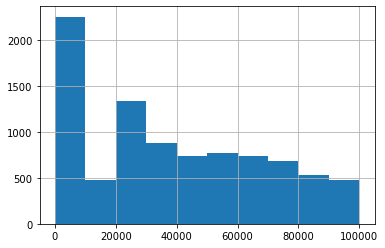

In [40]:
ca_df.income.hist()

Let us replace the zeros by the Income mean (calculated exlcuding zeros).

In [41]:
ca_df = replace_by(ca_df, ["income"], replace_zeros=True)

In [42]:
ca_df.income[ca_df.income == 0].size

0

<AxesSubplot:>

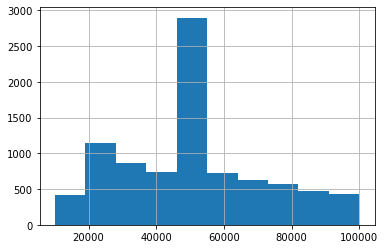

In [43]:
ca_df.income.hist()

Now that we don't have Nan values we can convert floats to integer if appropiate. In this case all the numeric columns can be converted to int without losing significant precision. Again we define a function for this.

In [44]:
float_to_int(ca_df, columns_list)
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8876 entries, 0 to 8875
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   st                         8875 non-null   object
 1   gender                     8753 non-null   object
 2   education                  8875 non-null   object
 3   customer_lifetime_value    8876 non-null   int32 
 4   income                     8876 non-null   int32 
 5   monthly_premium_auto       8876 non-null   int32 
 6   number_of_open_complaints  8876 non-null   int32 
 7   policy_type                8875 non-null   object
 8   vehicle_class              8875 non-null   object
 9   total_claim_amount         8876 non-null   int32 
dtypes: int32(5), object(5)
memory usage: 520.2+ KB


## Categorical columns

Nan value rows dropped in those column with only one occurrence. In the gender column Nan values replace by "U" (for Unknown).

In [45]:
print(nan_counter(ca_df))

{'st': 1, 'gender': 123, 'education': 1, 'customer_lifetime_value': 0, 'income': 0, 'monthly_premium_auto': 0, 'number_of_open_complaints': 0, 'policy_type': 1, 'vehicle_class': 1, 'total_claim_amount': 0}


In [46]:
ca_df = replace_by_cat(ca_df, [("gender", "U")])
ca_df.dropna(inplace=True)

In [47]:
print(nan_counter(ca_df))

{'st': 0, 'gender': 0, 'education': 0, 'customer_lifetime_value': 0, 'income': 0, 'monthly_premium_auto': 0, 'number_of_open_complaints': 0, 'policy_type': 0, 'vehicle_class': 0, 'total_claim_amount': 0}


Let us see how the data looks now.

In [48]:
ca_df

,st,gender,education,customer_lifetime_value,income,monthly_premium_auto,number_of_open_complaints,policy_type,vehicle_class,total_claim_amount
0,Washington,U,Master,17946226,50712,1000,0,Personal Auto,Four-Door Car,2
1,Arizona,F,Bachelor,69795359,50712,94,0,Personal Auto,Four-Door Car,1131
2,Nevada,F,Bachelor,128874317,48767,108,0,Personal Auto,Two-Door Car,566
3,California,M,Bachelor,76458618,50712,106,0,Corporate Auto,SUV,529
4,Washington,M,High School or Below,53630765,36357,68,0,Personal Auto,Four-Door Car,17
...,...,...,...,...,...,...,...,...,...,...
8871,California,M,Bachelor,23406,71941,73,0,Personal Auto,Four-Door Car,198
8872,California,F,College,3097,21604,79,0,Corporate Auto,Four-Door Car,379
8873,California,M,Bachelor,8164,50712,85,3,Corporate Auto,Four-Door Car,790
8874,California,M,College,7524,21941,96,0,Personal Auto,Four-Door Car,691


# Standardizing the data

In [49]:
ca_df_standarized = standardize_data(ca_df)

In [50]:
ca_df_standarized

,st,gender,education,customer_lifetime_value,income,monthly_premium_auto,number_of_open_complaints,policy_type,vehicle_class,total_claim_amount
0,washington,u,master,17946226,50712,1000,0,personal auto,four-door car,2
1,arizona,f,bachelor,69795359,50712,94,0,personal auto,four-door car,1131
2,nevada,f,bachelor,128874317,48767,108,0,personal auto,two-door car,566
3,california,m,bachelor,76458618,50712,106,0,corporate auto,suv,529
4,washington,m,high school or below,53630765,36357,68,0,personal auto,four-door car,17
...,...,...,...,...,...,...,...,...,...,...
8870,california,m,bachelor,23406,71941,73,0,personal auto,four-door car,198
8871,california,f,college,3097,21604,79,0,corporate auto,four-door car,379
8872,california,m,bachelor,8164,50712,85,3,corporate auto,four-door car,790
8873,california,m,college,7524,21941,96,0,personal auto,four-door car,691


In [51]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8875 entries, 0 to 8875
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   st                         8875 non-null   object
 1   gender                     8875 non-null   object
 2   education                  8875 non-null   object
 3   customer_lifetime_value    8875 non-null   int32 
 4   income                     8875 non-null   int32 
 5   monthly_premium_auto       8875 non-null   int32 
 6   number_of_open_complaints  8875 non-null   int32 
 7   policy_type                8875 non-null   object
 8   vehicle_class              8875 non-null   object
 9   total_claim_amount         8875 non-null   int32 
dtypes: int32(5), object(5)
memory usage: 589.4+ KB


# Plotting

First we import the csv file with all the data (provided on Wednesday)

In [52]:
ca_c_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
ca_c_df = standard_headings(ca_c_df)


## Pipeline Controller

In [53]:
drop_columns = ["unnamed:_0", "customer", "effective_to_date", "policy", "vehicle_type"]
bucket_columns = ["vehicle_class"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
clean_columns_zeros = ["income"]
clean_columns_cat = [("response", "No")]
float_columns = list(set(ca_c_df._get_numeric_data().columns).difference(set(drop_columns)))
obj_columns = list(set(ca_c_df.select_dtypes("object").columns).difference(set(drop_columns)))

cleaning_dict = {"Luxury SUV":"Luxury", "Luxury Car":"Luxury"
                 ,np.nan:np.nan
                 }

In [54]:
ca_c_df = (pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
#.pipe(dt_corrector)
.pipe(bucket_series, bucket_columns ,cleaning_dict)
#.drop_duplicates().reset_index(drop=True)
#.pipe(replace_by, clean_columns_NaN)
.pipe(replace_by, clean_columns_zeros)
.pipe(replace_by_cat, clean_columns_cat)
.dropna()
.pipe(standardize_data)
.pipe(float_to_int, float_columns)
.pipe(obj_to_cat, obj_columns)
)

In [55]:
ca_c_df

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,...,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,arizona,4809,no,basic,college,employed,m,48029,suburban,married,...,7,52,0,9,corporate auto,offer3,agent,292,four-door car,medsize
1,california,2228,no,basic,college,unemployed,f,0,suburban,single,...,3,26,0,1,personal auto,offer4,call center,744,four-door car,medsize
2,washington,14947,no,basic,bachelor,employed,m,22139,suburban,single,...,34,31,0,2,personal auto,offer3,call center,480,suv,medsize
3,oregon,22332,yes,extended,college,employed,m,49078,suburban,single,...,10,3,0,2,corporate auto,offer2,branch,484,four-door car,medsize
4,california,5035,no,basic,doctor,employed,f,37405,urban,married,...,8,99,3,4,corporate auto,offer2,branch,287,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,arizona,2771,no,basic,college,employed,m,59855,suburban,married,...,30,82,4,1,personal auto,offer2,branch,355,two-door car,medsize
9130,nevada,19228,no,basic,high school or below,unemployed,m,0,suburban,single,...,14,32,0,2,personal auto,offer1,branch,897,luxury,medsize
9131,oregon,5259,no,basic,college,employed,f,61146,urban,married,...,7,68,0,6,personal auto,offer2,branch,273,four-door car,medsize
9132,arizona,23893,no,extended,bachelor,employed,f,39837,rural,married,...,11,63,0,2,corporate auto,offer1,web,381,luxury,medsize


In [56]:
ca_c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   state                          9134 non-null   category
 1   customer_lifetime_value        9134 non-null   int32   
 2   response                       9134 non-null   category
 3   coverage                       9134 non-null   category
 4   education                      9134 non-null   category
 5   employmentstatus               9134 non-null   category
 6   gender                         9134 non-null   category
 7   income                         9134 non-null   int32   
 8   location_code                  9134 non-null   category
 9   marital_status                 9134 non-null   category
 10  monthly_premium_auto           9134 non-null   int32   
 11  months_since_last_claim        9134 non-null   int32   
 12  months_since_policy_inception  913

In [57]:
nan_counter(ca_c_df)

{'state': 0,
 'customer_lifetime_value': 0,
 'response': 0,
 'coverage': 0,
 'education': 0,
 'employmentstatus': 0,
 'gender': 0,
 'income': 0,
 'location_code': 0,
 'marital_status': 0,
 'monthly_premium_auto': 0,
 'months_since_last_claim': 0,
 'months_since_policy_inception': 0,
 'number_of_open_complaints': 0,
 'number_of_policies': 0,
 'policy_type': 0,
 'renew_offer_type': 0,
 'sales_channel': 0,
 'total_claim_amount': 0,
 'vehicle_class': 0,
 'vehicle_size': 0}

## Plot of the total number of responses

We create a new variable with the categories in Respone column [Yes, No].

In [58]:
response = ca_c_df["response"].value_counts(dropna=False)
response

no     7826
yes    1308
Name: response, dtype: int64

Following code plots and shows the total response as a bar plot.

In [59]:
# theme
sns.set_theme(style="darkgrid")

<BarContainer object of 2 artists>

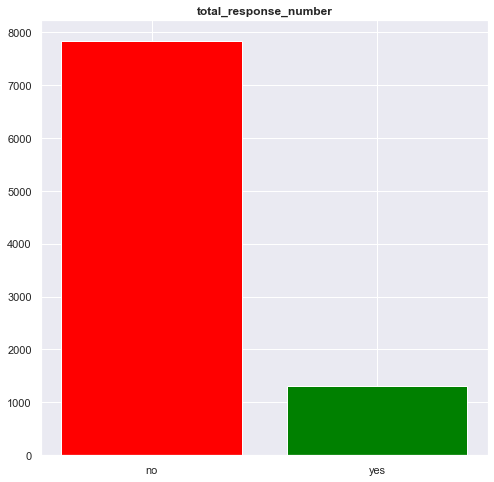

In [60]:
# create figure and axes
fig1, ax1 = plt.subplots(figsize = (8,8))

# set title
ax1.set_title('total_response_number', fontweight='bold')

# plot the bar chart
ax1.bar(response.index, response, color=('red','green', 'black'))

## Plot of the response rate by the sales channel.

In [61]:
response_channel_rate = variable_rate_vs(ca_c_df, "response", "sales_channel")

<BarContainer object of 4 artists>

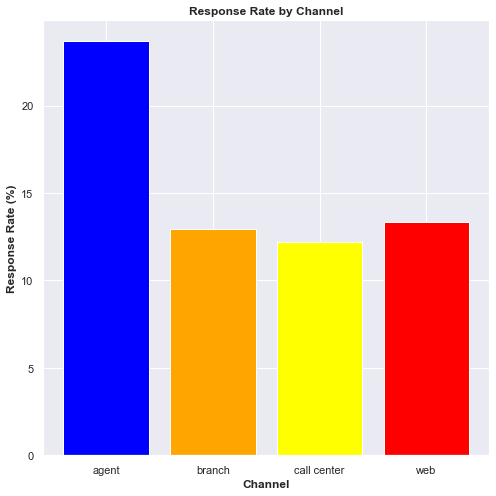

In [62]:
# create figure and axes
fig2, ax2 = plt.subplots(figsize = (8,8))

# set title
ax2.set_title('Response Rate by Channel', fontweight='bold')

# axes titles
ax2.set_xlabel("Channel", fontweight='bold')
ax2.set_ylabel("Response Rate (%)", fontweight='bold')

# plot the bar chart
ax2.bar(response_channel_rate.index, response_channel_rate, color=('blue','orange', 'yellow', "red"))

C:\Users\ehern\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


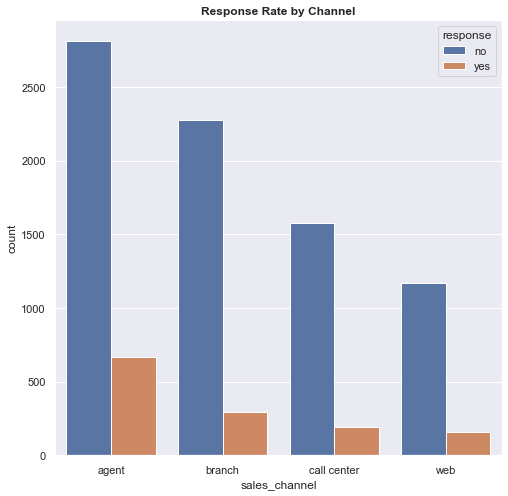

In [63]:
# create figure and axes
fig2b, ax2b = plt.subplots(figsize = (8,8))

# set title
ax2b.set_title('Response Rate by Channel', fontweight='bold')

# plot the bar chart
ax2b = sns.countplot("sales_channel", hue="response", data = ca_c_df)

Following code plots and shows the total response as a bar plot.

## Plot of the response rate by the Total Claim Amount.

First I will bin the Total Claim Amount into categories.

In [64]:
total_claim_amount_labels = ['Low', 'Moderate', 'High']
ca_c_df['total_claim_amount_binned'] = pd.cut(ca_c_df['total_claim_amount'],3, labels=total_claim_amount_labels)

In [65]:
ca_c_df.head()

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,total_claim_amount_binned
0,arizona,4809,no,basic,college,employed,m,48029,suburban,married,...,52,0,9,corporate auto,offer3,agent,292,four-door car,medsize,Low
1,california,2228,no,basic,college,unemployed,f,0,suburban,single,...,26,0,1,personal auto,offer4,call center,744,four-door car,medsize,Low
2,washington,14947,no,basic,bachelor,employed,m,22139,suburban,single,...,31,0,2,personal auto,offer3,call center,480,suv,medsize,Low
3,oregon,22332,yes,extended,college,employed,m,49078,suburban,single,...,3,0,2,corporate auto,offer2,branch,484,four-door car,medsize,Low
4,california,5035,no,basic,doctor,employed,f,37405,urban,married,...,99,3,4,corporate auto,offer2,branch,287,four-door car,medsize,Low


Then fuction variable_rate_vs() can be used.

In [66]:
response_total_claim_amount_rate = variable_rate_vs(ca_c_df, "response", "total_claim_amount_binned")


In [67]:
response_total_claim_amount_rate

Low         16.77
Moderate    16.81
High         0.00
dtype: float64

Following code plots and shows the total response as a bar plot.

<BarContainer object of 3 artists>

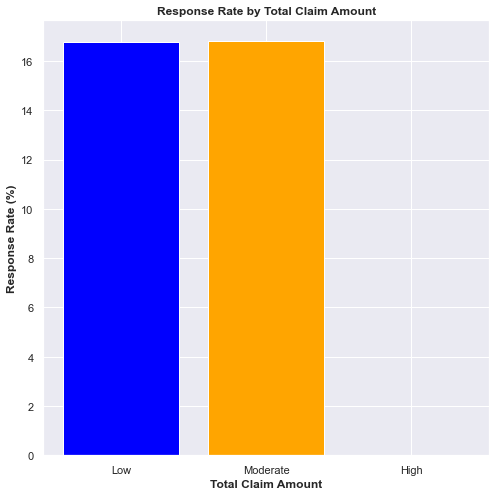

In [68]:
# create figure and axes
fig3, ax3 = plt.subplots(figsize = (8,8))

# set title
ax3.set_title('Response Rate by Total Claim Amount', fontweight='bold')

# axes titles
ax3.set_xlabel("Total Claim Amount", fontweight='bold')
ax3.set_ylabel("Response Rate (%)", fontweight='bold')

# plot the bar chart
ax3.bar(response_total_claim_amount_rate.index, response_total_claim_amount_rate, color=('blue','orange', 'yellow', "red", "black"))

C:\Users\ehern\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


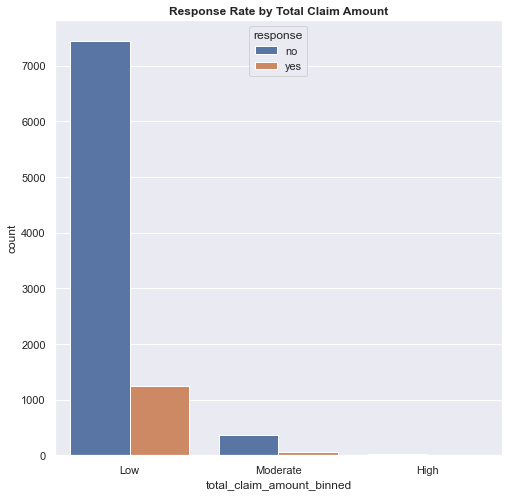

In [69]:
# create figure and axes
fig3b, ax3b = plt.subplots(figsize = (8,8))

# set title
ax3b.set_title('Response Rate by Total Claim Amount', fontweight='bold')

# plot the bar chart
ax3b = sns.countplot("total_claim_amount_binned", hue="response", data = ca_c_df)

Let us do some checks.

In [70]:
ca_c_df["response"][ca_c_df.total_claim_amount_binned == ("High" or "Very High")].value_counts()

no     29
yes     0
Name: response, dtype: int64

The high and very high claims are not responded, which kind of makes sense.

## Plot of the response rate by income

The approach is very simmilar to that for the income.

In [71]:
income_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
ca_c_df['income_binned'] = pd.cut(ca_c_df['income'],5, labels=income_labels)

In [72]:
ca_c_df.head()

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,...,number_of_open_complaints,number_of_policies,policy_type,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,total_claim_amount_binned,income_binned
0,arizona,4809,no,basic,college,employed,m,48029,suburban,married,...,0,9,corporate auto,offer3,agent,292,four-door car,medsize,Low,Moderate
1,california,2228,no,basic,college,unemployed,f,0,suburban,single,...,0,1,personal auto,offer4,call center,744,four-door car,medsize,Low,Very Low
2,washington,14947,no,basic,bachelor,employed,m,22139,suburban,single,...,0,2,personal auto,offer3,call center,480,suv,medsize,Low,Low
3,oregon,22332,yes,extended,college,employed,m,49078,suburban,single,...,0,2,corporate auto,offer2,branch,484,four-door car,medsize,Low,Moderate
4,california,5035,no,basic,doctor,employed,f,37405,urban,married,...,3,4,corporate auto,offer2,branch,287,four-door car,medsize,Low,Low


In [73]:
response_income_rate = variable_rate_vs(ca_c_df, "response", "income_binned")


In [74]:
response_income_rate

Very Low     14.52
Low          21.86
Moderate     14.24
High         19.13
Very High    12.53
dtype: float64

<BarContainer object of 5 artists>

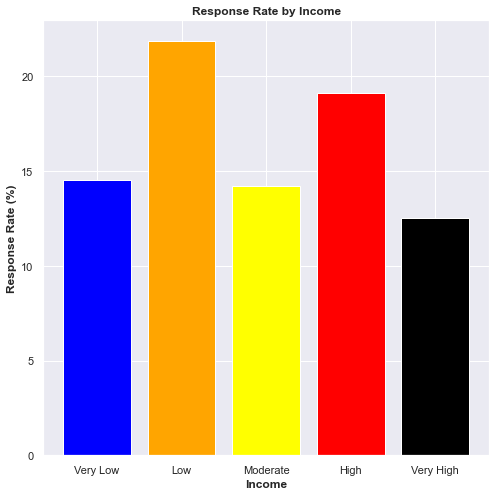

In [75]:
# create figure and axes
fig4, ax4 = plt.subplots(figsize = (8,8))

# set title
ax4.set_title('Response Rate by Income', fontweight='bold')

# axes titles
ax4.set_xlabel("Income", fontweight='bold')
ax4.set_ylabel("Response Rate (%)", fontweight='bold')

# plot the bar chart
ax4.bar(response_income_rate.index, response_income_rate, color=('blue','orange', 'yellow', "red", "black"))

C:\Users\ehern\miniconda3\envs\DA_ENV\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


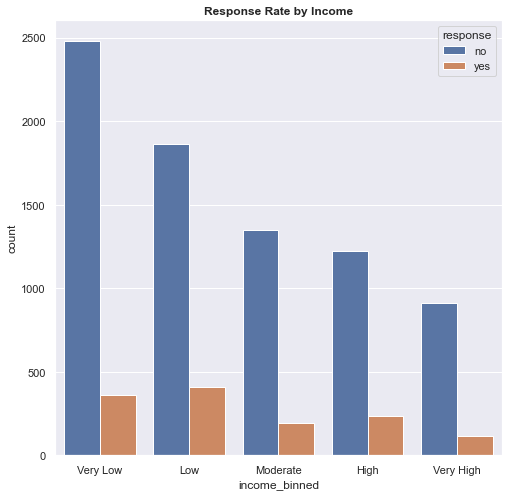

In [76]:
# create figure and axes
fig4b, ax4b = plt.subplots(figsize = (8,8))

# set title
ax4b.set_title('Response Rate by Income', fontweight='bold')

# plot the bar chart
ax4b = sns.countplot("income_binned", hue="response", data = ca_c_df)

Seems like the income does not correlate with the response rate. Before the analysis I would have assumed that the claims of the High-Very High income clients will be responded more often. 

## Plot the Correlation Heatmap.

We will apply method pd.corr() only to the numerical columns

In [77]:
ca_c_num_df = ca_c_df._get_numeric_data()
correlation_matrix = ca_c_num_df.corr()



In [78]:
correlation_matrix

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer_lifetime_value,1.000000,0.024365,0.396262,0.011516,0.009419,-0.036342,0.021956,0.226454
income,0.024365,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355249
monthly_premium_auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632012
months_since_last_claim,0.011516,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007541
months_since_policy_inception,0.009419,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003345
number_of_open_complaints,-0.036342,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014253
number_of_policies,0.021956,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002379
total_claim_amount,0.226454,-0.355249,0.632012,0.007541,0.003345,-0.014253,-0.002379,1.000000


We plot the heatmap with seaborn fuction sns.

<AxesSubplot:title={'center':'Correlation Heatmap'}>

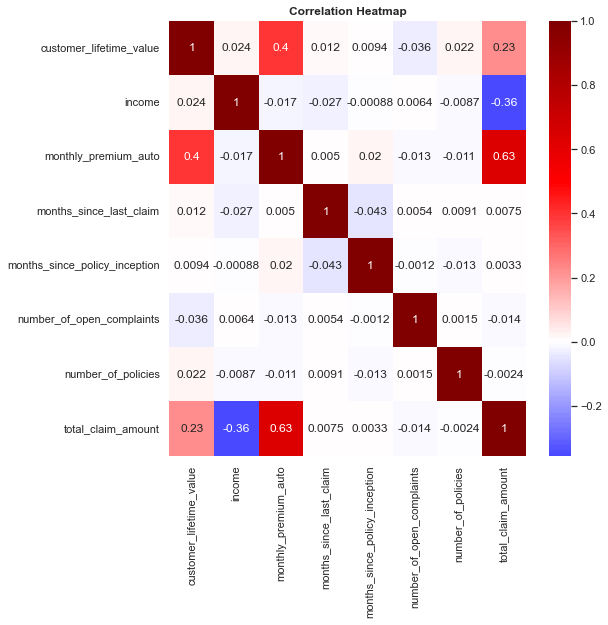

In [79]:
# create figure and axes
fig5, ax5 = plt.subplots(figsize = (8,8))

# set title
ax5.set_title('Correlation Heatmap', fontweight='bold')



sns.heatmap(correlation_matrix,  # the data for the heatmap
                          annot=True,  # show the actual values of correlation
                          cmap='seismic',  # provide the 'seismic' colormap
                          center=0,  # specify the value at which to center the colormap
                          )

## Numerical and Categorical Columns

In [80]:
ca_c_num_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,0,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,5035,37405,63,8,99,3,4,287
...,...,...,...,...,...,...,...,...
9129,2771,59855,74,30,82,4,1,355
9130,19228,0,187,14,32,0,2,897
9131,5259,61146,65,7,68,0,6,273
9132,23893,39837,201,11,63,0,2,381


In [81]:
ca_c_cat_df = ca_c_df.select_dtypes("object")
ca_c_cat_df

""
0
1
2
3
4
...
9129
9130
9131
9132


## Distribution plots

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

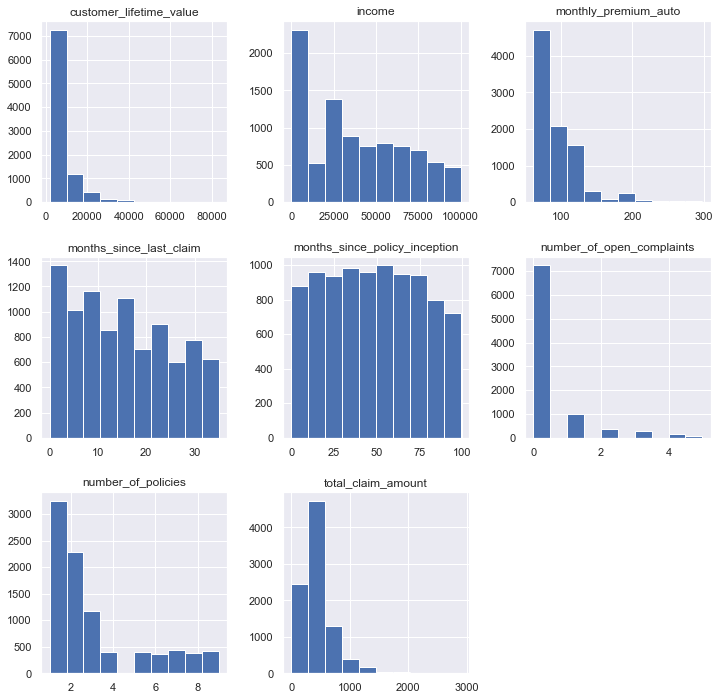

In [82]:
# Using Pandas

ca_c_num_df.hist(figsize=(12,12))

In [83]:
#using sns and dedicated function

def dist_plot(df, ncolumns):

    columns = np.array(df.columns)
    nrows = (len(columns) % ncolumns) + 1

    fig, axs = plt.subplots(nrows, ncolumns, figsize = (16,16))

    pad_value = (nrows - (len(columns) // nrows))
    columns = np.pad(columns, pad_value, constant_values = "")[pad_value:]
    columns = columns.reshape(nrows, ncolumns)


    for i in range(nrows):

        for j in range(ncolumns):

            try:

                sns.histplot(df, x = columns[i,j], ax = axs[i, j])

            except:
                continue



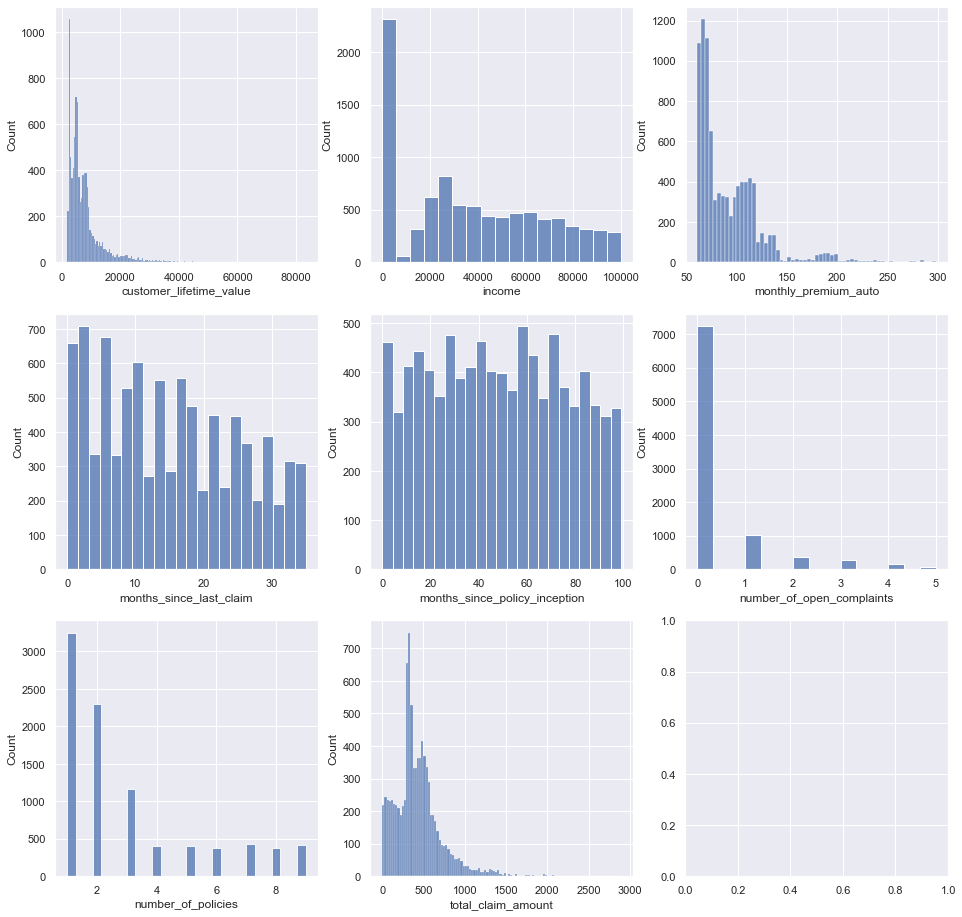

In [84]:
dist_plot(ca_c_num_df, 3)

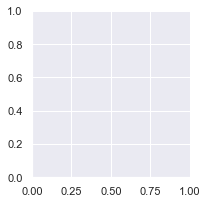

In [85]:
g = sns.FacetGrid(ca_c_num_df)

In [86]:
#using sns FacetGrid


# First we melt the dataframe to have all data in one single column
ca_c_num_df_melted = ca_c_num_df.melt(var_name="column")


In [87]:
ca_c_num_df_melted.head()

,column,value
0,customer_lifetime_value,4809
1,customer_lifetime_value,2228
2,customer_lifetime_value,14947
3,customer_lifetime_value,22332
4,customer_lifetime_value,5035


In [88]:
ca_c_num_df_melted.tail()

,column,value
73067,total_claim_amount,355
73068,total_claim_amount,897
73069,total_claim_amount,273
73070,total_claim_amount,381
73071,total_claim_amount,618


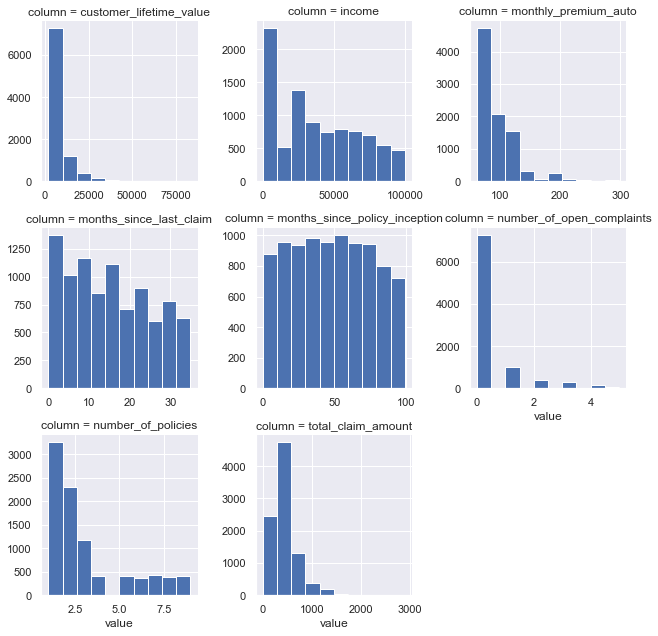

In [89]:
# FacetGrid
g = sns.FacetGrid(ca_c_num_df_melted, col='column', col_wrap=3, sharex=False, sharey=False)
g.map(plt.hist, 'value')

None of the numerical variables seems to be normally distributed.

## Multicollinearity

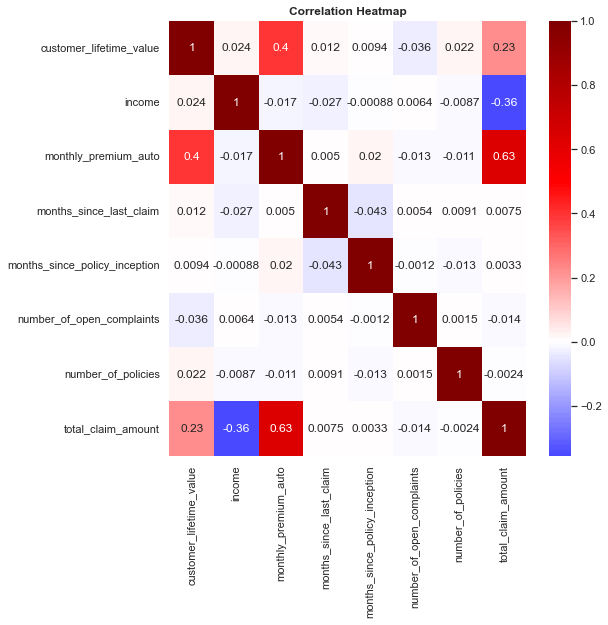

In [90]:
fig5

There are no high correlated feature pairs in the dataset.

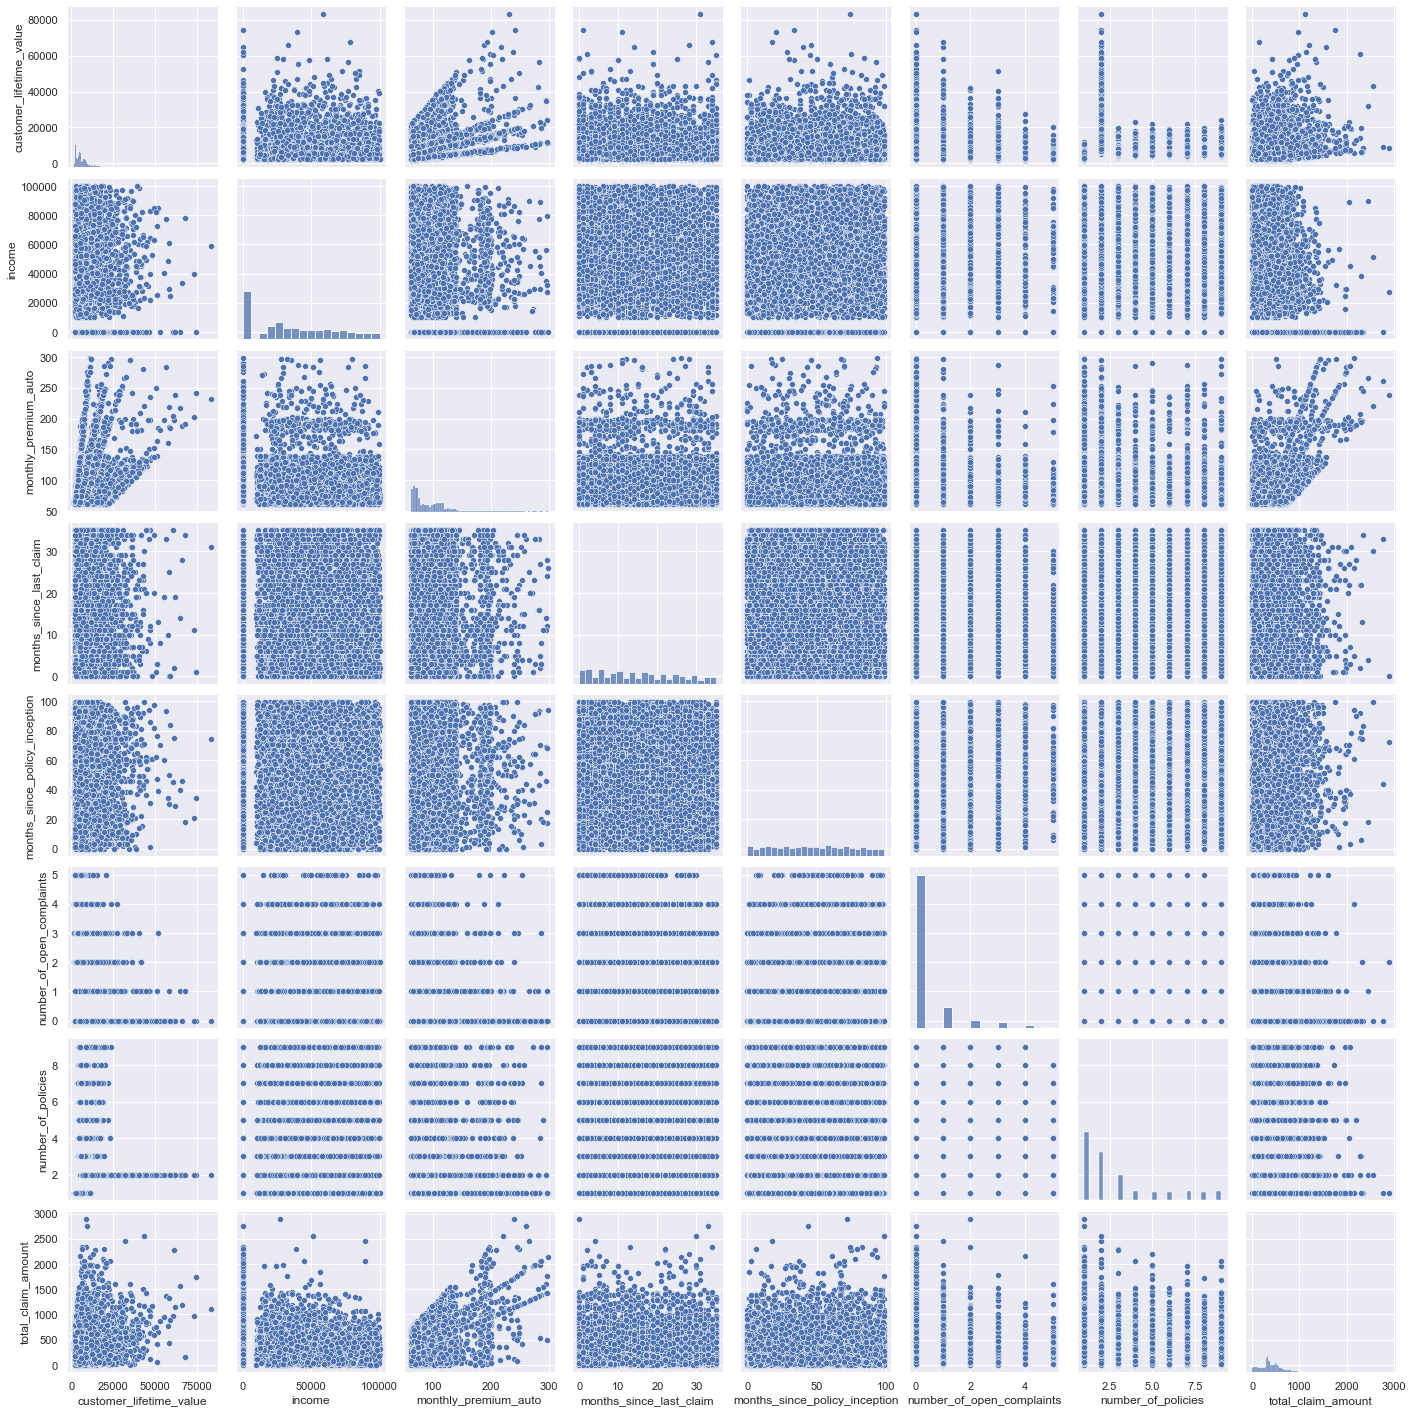

In [91]:
sns.pairplot(ca_c_num_df)

# Data Transformation

## x-y split

First we separate the dependent variable (Y) from the independent variables (X)

In [92]:
X = ca_c_df.drop("total_claim_amount", axis=1)
y = ca_c_df["total_claim_amount"]

We allocate the categorical variable and the numerical variables.

In [93]:
X_num = X._get_numeric_data()
X_cat = X.select_dtypes("object")

## Normalize numerical variables

### Min-max normalization

In [94]:
X_num_scaled_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X_num), columns=X_num.columns)
X_num_scaled_minmax


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,0.035750,0.480381,0.000000,0.200000,0.525253,0.0,1.000
1,0.004053,0.000000,0.012658,0.085714,0.262626,0.0,0.000
2,0.160254,0.221432,0.164557,0.971429,0.313131,0.0,0.125
3,0.250949,0.490873,0.151899,0.285714,0.030303,0.0,0.125
4,0.038525,0.374121,0.008439,0.228571,1.000000,0.6,0.375
...,...,...,...,...,...,...,...
9129,0.010721,0.598664,0.054852,0.857143,0.828283,0.8,0.000
9130,0.212829,0.000000,0.531646,0.400000,0.323232,0.0,0.125
9131,0.041276,0.611576,0.016878,0.200000,0.686869,0.0,0.625
9132,0.270119,0.398446,0.590717,0.314286,0.636364,0.0,0.125


### Standard normalization

In [95]:
X_num_scaled_standard = pd.DataFrame(StandardScaler().fit_transform(X_num), columns=X_num.columns)
X_num_scaled_standard

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,-0.465089,0.341416,-0.936442,-0.803856,0.141031,-0.422250,2.524561
1,-0.840748,-1.239617,-0.849248,-1.200968,-0.790719,-0.422250,-0.822648
2,1.010475,-0.510839,0.197079,1.876656,-0.611536,-0.422250,-0.404247
3,2.085346,0.375947,0.109885,-0.506021,-1.614960,-0.422250,-0.404247
4,-0.432195,-0.008308,-0.878312,-0.704577,1.825350,2.873245,0.432555
...,...,...,...,...,...,...,...
9129,-0.761716,0.730708,-0.558602,1.479543,1.216128,3.971744,-0.822648
9130,1.633566,-1.239617,2.725701,-0.108908,-0.575700,-0.422250,-0.404247
9131,-0.399592,0.773205,-0.820183,-0.803856,0.714416,-0.422250,1.269358
9132,2.312546,0.071749,3.132606,-0.406743,0.535234,-0.422250,-0.404247


## Categorical Variables Enconding

In [96]:
X_cat.head()

""
0
1
2
3
4


In [97]:
X_cat["vehicle_size"].value_counts(dropna=False)

KeyError: 'vehicle_size'

### Ordinal Encoding

In [ ]:
X_cat_ord = X_cat[["response", "coverage", "education", "renew_offer_type", "vehicle_size"]]
categories = [["no","yes"], ["basic", "extended", "premium"], ["high school or below", "college", "bachelor", "master", "doctor"], ["offer1", "offer2", "offer3", "offer4"], ["not defined", "small", "medsize", "large"]]

ordinal_encoder = OrdinalEncoder(categories=categories)
X_cat_ord_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_cat_ord),columns=X_cat_ord.columns)

In [ ]:
X_cat_ord_encoded

,response,coverage,education,renew_offer_type,vehicle_size
0,0.0,0.0,1.0,2.0,2.0
1,0.0,0.0,1.0,3.0,2.0
2,0.0,0.0,2.0,2.0,2.0
3,1.0,1.0,1.0,1.0,2.0
4,0.0,0.0,4.0,1.0,2.0
...,...,...,...,...,...
9129,0.0,0.0,1.0,1.0,2.0
9130,0.0,0.0,0.0,0.0,2.0
9131,0.0,0.0,1.0,1.0,2.0
9132,0.0,1.0,2.0,0.0,2.0


### One Hot Encoding (For Nominal Variables)

In [ ]:
X_cat

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,renew_offer_type,sales_channel,vehicle_class,vehicle_size
0,arizona,no,basic,college,employed,m,suburban,married,corporate auto,offer3,agent,four-door car,medsize
1,california,no,basic,college,unemployed,f,suburban,single,personal auto,offer4,call center,four-door car,medsize
2,washington,no,basic,bachelor,employed,m,suburban,single,personal auto,offer3,call center,suv,medsize
3,oregon,yes,extended,college,employed,m,suburban,single,corporate auto,offer2,branch,four-door car,medsize
4,california,no,basic,doctor,employed,f,urban,married,corporate auto,offer2,branch,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,arizona,no,basic,college,employed,m,suburban,married,personal auto,offer2,branch,two-door car,medsize
9130,nevada,no,basic,high school or below,unemployed,m,suburban,single,personal auto,offer1,branch,luxury,medsize
9131,oregon,no,basic,college,employed,f,urban,married,personal auto,offer2,branch,four-door car,medsize
9132,arizona,no,extended,bachelor,employed,f,rural,married,corporate auto,offer1,web,luxury,medsize


In [ ]:
X_cat_nom = X_cat.drop(X_cat_ord.columns, axis=1)
X_cat_nom

,state,employmentstatus,gender,location_code,marital_status,policy_type,sales_channel,vehicle_class
0,arizona,employed,m,suburban,married,corporate auto,agent,four-door car
1,california,unemployed,f,suburban,single,personal auto,call center,four-door car
2,washington,employed,m,suburban,single,personal auto,call center,suv
3,oregon,employed,m,suburban,single,corporate auto,branch,four-door car
4,california,employed,f,urban,married,corporate auto,branch,four-door car
...,...,...,...,...,...,...,...,...
9129,arizona,employed,m,suburban,married,personal auto,branch,two-door car
9130,nevada,unemployed,m,suburban,single,personal auto,branch,luxury
9131,oregon,employed,f,urban,married,personal auto,branch,four-door car
9132,arizona,employed,f,rural,married,corporate auto,web,luxury


In [ ]:
# with pd.get_dummies()
X_cat_nom_encoded = pd.get_dummies(X_cat_nom,drop_first=True)

#drop_first = True creates K-1 columns





In [ ]:
# with sklearn

X_cat_nom_encoded = pd.DataFrame(OneHotEncoder(drop="first").fit_transform(X_cat_nom).toarray(),
                             columns=OneHotEncoder(drop='first').fit(X_cat_nom).get_feature_names_out(input_features=X_cat_nom.columns))
X_cat_nom_encoded


,state_california,state_nevada,state_oregon,state_washington,employmentstatus_employed,employmentstatus_medical leave,employmentstatus_retired,employmentstatus_unemployed,gender_m,location_code_suburban,...,marital_status_single,policy_type_personal auto,policy_type_special auto,sales_channel_branch,sales_channel_call center,sales_channel_web,vehicle_class_luxury,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9130,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9131,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Function for Transformations

In [44]:
def my_transformations(df, test_size=0.2, scaler = "minmax"):

    # x-y split

    X = df.drop("total_claim_amount", axis=1)
    y = df["total_claim_amount"]

    # Train/Test Split
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size= test_size, random_state=0)
    
    
    # Numerical and categorical variables

    X_train_num = X_train._get_numeric_data()
    X_test_num = X_test._get_numeric_data()
    X_train_cat = X_train.select_dtypes("category")
    X_test_cat = X_test.select_dtypes("category")

    # Categorical Variables Encoding - Ordinals

    X_train_cat_ord = X_train_cat[["response", "coverage", "education", "renew_offer_type", "vehicle_size"]]
    X_test_cat_ord = X_test_cat[["response", "coverage", "education", "renew_offer_type", "vehicle_size"]]

    categories = [["no","yes"], ["basic", "extended", "premium"], ["high school or below", "college", "bachelor", "master", "doctor"], ["offer1", "offer2", "offer3", "offer4"], ["not defined", "small", "medsize", "large"]]
    
    ordinal_encoder = OrdinalEncoder(categories=categories)
    X_train_cat_ord_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_train_cat_ord),columns=X_train_cat_ord.columns).reset_index(drop=True)
    X_test_cat_ord_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X_test_cat_ord),columns=X_test_cat_ord.columns).reset_index(drop=True)
    
    # Categorical Variables Encoding - Nominals

    X_train_cat_nom = X_train_cat.drop(X_train_cat_ord.columns, axis=1)
    X_test_cat_nom = X_test_cat.drop(X_test_cat_ord.columns, axis=1)

    X_train_cat_nom_encoded = pd.get_dummies(X_train_cat_nom,drop_first=True).reset_index(drop=True)
    X_test_cat_nom_encoded = pd.get_dummies(X_test_cat_nom,drop_first=True).reset_index(drop=True)

    X_train_cat = pd.concat([X_train_cat_nom_encoded, X_train_cat_ord_encoded], axis=1)
    X_test_cat = pd.concat([X_test_cat_nom_encoded, X_test_cat_ord_encoded], axis=1)
    
    
    if scaler != None:
       
       if scaler == "minmax":
           
           scaler = MinMaxScaler()
           
       elif scaler == "standard":
           
           scaler = StandardScaler()
    
       scaler.fit(X_train_num)
       X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num), columns=X_train_num.columns).reset_index(drop=True)
       X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns).reset_index(drop=True)
    
       return {"train":[X_train_num_scaled, X_train_cat, y_train], "test":[X_test_num_scaled, X_test_cat, y_test]}

    return {"train":[X_train_num, X_train_cat, y_train], "test":[X_test_num, X_test_cat, y_test]}

# Linear Regression

## General function to split the data, fit the linear regression, plot the results and return y_pred, fitting coefficients and the error metrics

In [45]:
def R2_adjusted(x, y, y_pred, R2=None):
    
    if R2==None:
    
        R2 = r2_score(y, y_pred)
    
    else:
        R2_adj = 1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)

    return R2_adj

In [46]:

def prediction_plot(model, X, y, set="test", y_transformer = None, verbose = True, plot = True):
    
    # Predict
    y_pred = model.predict(X)

    # Do the inverse normal transformation to return the dependent variable to meaningfull values
    if y_transformer != None:

        if y_transformer != "log":

            y = pd.DataFrame(y_transformer.inverse_transform(np.array(y).reshape(-1, 1)))[0]
            y_pred = pd.DataFrame(y_transformer.inverse_transform(y_pred.reshape(-1, 1)))[0]
        
        elif y_transformer == "log":

            y = np.exp(y)
            y_pred = np.exp(y_pred)


    result = pd.DataFrame({f"y_{set}":y, "y_pred":y_pred})

    # Metrics
    
    R2 = r2_score(y, y_pred)
    RMSE = mse(y, y_pred, squared=False)
    R2_adj = R2_adjusted(X, y, y_pred, R2)
    metrics = {"MSE":mse(y, y_pred), "RMSE":RMSE, "MAE":mae(y, y_pred), "R2":R2, "R2_adj":R2_adj}


    if verbose:

        print(f"The model performance for the {set} set")
        print("-------------------------------------------")
        print(f"RMSE of {set} set is {RMSE}")
        print(f"Adjusted R2 score of {set} set is {R2_adj}")
        print()

    # Plots

    if plot:

        fig, axs = plt.subplots(1,3,figsize=(15,5))

        fs = 11
    
        plt.xticks(fontsize = fs)

        sns.regplot(x=f"y_{set}", y="y_pred", data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs[0])
        sns.histplot(y-y_pred, kde=True, ax=axs[1])
        axs[2].plot(y_pred,y - y_pred,"o")
        axs[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

        axs[0].set_title(f"y_{set}".capitalize() + " Set - Observed VS Predicted", fontsize = fs)
        axs[1].set_title(f"y_{set}".capitalize() + " Set - Histogram of the Residuals", fontsize = fs)
        axs[1].set_xlabel(f"y_{set}" + " - y_pred", fontsize = fs)
        axs[2].set_xlabel("Predicted", fontsize = fs)
        axs[2].set_ylabel("Residuals", fontsize = fs)
        axs[2].set_title("Residuals by Predicted", fontsize = fs)

    

    return {"Result":result, "Metrics":metrics}

In [47]:
def my_flex_regression(X_train, y_train, X_test, y_test, model, verbose = True, plot = True, y_transformer = None, **kwargs):

    # Model Fit
    model.set_params(**kwargs)
    model.fit(X_train, y_train)

    # Evaluation on the Train Set
    train = prediction_plot(model, X_train, y_train, set="train", y_transformer = y_transformer, verbose = verbose, plot = plot)

    # Evaluation on the Test Set
    test = prediction_plot(model, X_test, y_test, set="test", y_transformer = y_transformer, verbose = verbose, plot = plot)

    dict_for_df = {"train": train["Metrics"], "test": test["Metrics"]}
    df_metrics = pd.DataFrame(dict_for_df)

    return {"Model":model, "Metrics": df_metrics, "Train":train, "Test":test}



## Baseline Approach - only with numerical variables


In [ ]:
ca_c_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
ca_c_df = standard_headings(ca_c_df)


In [ ]:
drop_columns = ["unnamed:_0", "customer", "effective_to_date", "policy", "vehicle_type"]
bucket_columns = ["vehicle_class"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
clean_columns_zeros = ["income"]
clean_columns_cat = [("response", "No")]
float_columns = list(set(ca_c_df._get_numeric_data().columns).difference(set(drop_columns)))
obj_columns = list(set(ca_c_df.select_dtypes("object").columns).difference(set(drop_columns)))

cleaning_dict = {"Luxury SUV":"Luxury", "Luxury Car":"Luxury"
                 ,np.nan:np.nan
                 }

In [ ]:
ca_c_df = (pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
#.pipe(dt_corrector)
.pipe(bucket_series, bucket_columns ,cleaning_dict)
#.drop_duplicates().reset_index(drop=True)
#.pipe(replace_by, clean_columns_NaN)
.pipe(replace_by, clean_columns_zeros, replace_zeros = True)
.pipe(replace_by_cat, clean_columns_cat)
.dropna()
.pipe(standardize_data)
.pipe(float_to_int, float_columns)
.pipe(obj_to_cat, obj_columns)
)

In [ ]:
ca_c_df

,state,customer_lifetime_value,response,coverage,education,employmentstatus,gender,income,location_code,marital_status,...,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,arizona,4809,no,basic,college,employed,m,48029,suburban,married,...,7,52,0,9,corporate auto,offer3,agent,292,four-door car,medsize
1,california,2228,no,basic,college,unemployed,f,0,suburban,single,...,3,26,0,1,personal auto,offer4,call center,744,four-door car,medsize
2,washington,14947,no,basic,bachelor,employed,m,22139,suburban,single,...,34,31,0,2,personal auto,offer3,call center,480,suv,medsize
3,oregon,22332,yes,extended,college,employed,m,49078,suburban,single,...,10,3,0,2,corporate auto,offer2,branch,484,four-door car,medsize
4,california,5035,no,basic,doctor,employed,f,37405,urban,married,...,8,99,3,4,corporate auto,offer2,branch,287,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9129,arizona,2771,no,basic,college,employed,m,59855,suburban,married,...,30,82,4,1,personal auto,offer2,branch,355,two-door car,medsize
9130,nevada,19228,no,basic,high school or below,unemployed,m,0,suburban,single,...,14,32,0,2,personal auto,offer1,branch,897,luxury,medsize
9131,oregon,5259,no,basic,college,employed,f,61146,urban,married,...,7,68,0,6,personal auto,offer2,branch,273,four-door car,medsize
9132,arizona,23893,no,extended,bachelor,employed,f,39837,rural,married,...,11,63,0,2,corporate auto,offer1,web,381,luxury,medsize


### With Standard Normalization

In [ ]:
transformed = my_transformations(ca_c_df, test_size=0.2, scaler="standard")


In [ ]:

X_train = transformed["train"][0]
y_train = transformed["train"][2]

X_test = transformed["test"][0]
y_test = transformed["test"][2]


The model performance for the train set
-------------------------------------------
RMSE of train set is 202.75374371326737
Adjusted R2 score of train set is 0.5093116192123813

The model performance for the test set
-------------------------------------------
RMSE of test set is 196.85714802738647
Adjusted R2 score of test set is 0.5429241112558889


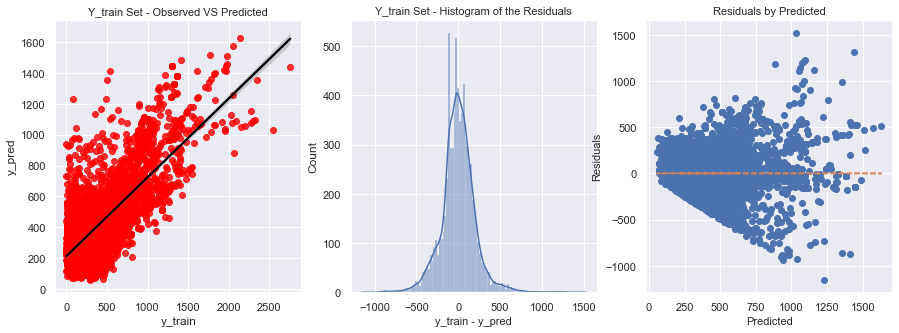

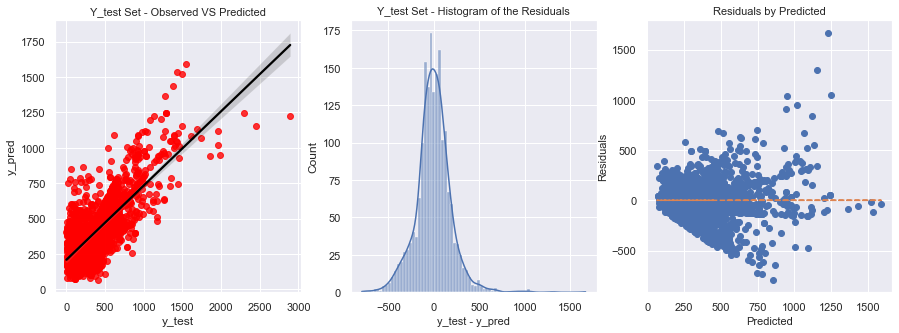

In [ ]:
output_baseline = my_flex_regression(X_train, y_train, X_test, y_test, LinearRegression(), y_transformer=None)

In [ ]:
output_baseline["Test"]["Metrics"]

{'MSE': 38752.73672947635,
 'RMSE': 196.85714802738647,
 'MAE': 140.4183907379007,
 'R2': 0.5484310496744926,
 'R2_adj': 0.5429241112558889}

The error seems to follow a normal distribution. Nevertheless it is too high and can be reduced.

### With Min-Max Normalization

In [43]:
transformed = my_transformations(ca_c_df, test_size=0.2, scaler="minmax")

X_train = transformed["train"][0]
y_train = transformed["train"][2]

X_test = transformed["test"][0]
y_test = transformed["test"][2]

NameError: name 'my_transformations' is not defined

The model performance for the train set
-------------------------------------------
RMSE of train set is 202.75374371326737
Adjusted R2 score of train set is 0.5093116192123813

The model performance for the test set
-------------------------------------------
RMSE of test set is 196.85714802738647
Adjusted R2 score of test set is 0.5429241112558889


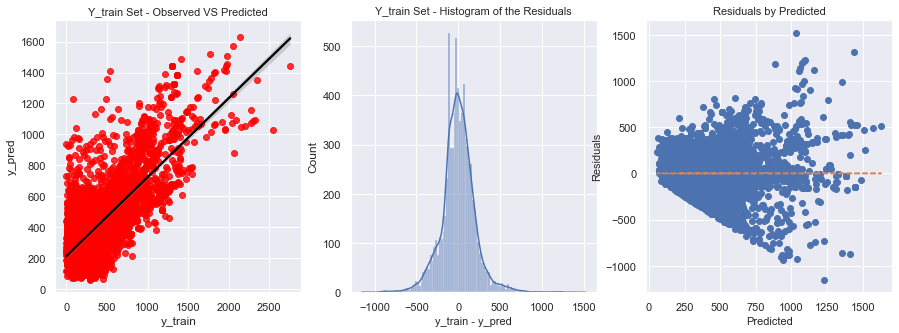

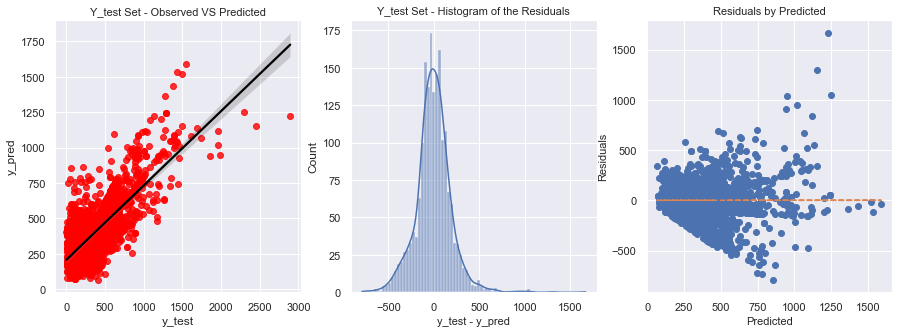

In [ ]:
output_baseline = my_flex_regression(X_train, y_train, X_test, y_test, LinearRegression(), y_transformer=None)

In [ ]:
output_baseline["Test"]["Metrics"]

{'MSE': 38752.73672947635,
 'RMSE': 196.85714802738647,
 'MAE': 140.4183907379007,
 'R2': 0.5484310496744926,
 'R2_adj': 0.5429241112558889}

**The normalization method has no impact in this case**

## Including All Categorical Variables

In [ ]:
transformed = my_transformations(ca_c_df, test_size=0.2, scaler="minmax")

X_train = pd.concat([transformed["train"][0], transformed["train"][1]], axis=1)
y_train = transformed["train"][2]

X_test = pd.concat([transformed["test"][0], transformed["test"][1]], axis=1)
y_test = transformed["test"][2]

In [ ]:
X_train

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,state_california,state_nevada,state_oregon,...,sales_channel_web,vehicle_class_luxury,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size
0,0.011065,0.653634,0.033755,0.114286,0.545455,0.0,0.000,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,2.0
1,0.048497,0.235005,0.067511,0.485714,0.888889,0.0,0.875,0,0,1,...,1,0,0,0,0,0.0,1.0,1.0,2.0,2.0
2,0.153892,0.000000,0.578059,0.114286,0.313131,0.0,1.000,0,0,0,...,0,1,0,0,0,0.0,0.0,0.0,3.0,1.0
3,0.055068,0.000000,0.109705,0.400000,0.676768,0.0,0.250,0,0,0,...,1,0,0,0,0,0.0,1.0,0.0,1.0,2.0
4,0.092991,0.465388,0.080169,0.342857,0.464646,0.2,0.125,1,0,0,...,0,0,0,0,0,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0.356982,0.000000,0.202532,0.514286,0.020202,0.0,0.125,0,0,1,...,0,0,0,1,0,0.0,0.0,2.0,2.0,1.0
7303,0.176882,0.196177,0.101266,0.600000,0.323232,0.0,0.125,0,0,1,...,0,0,0,0,1,1.0,1.0,3.0,1.0,2.0
7304,0.040859,0.577440,0.021097,0.685714,0.666667,0.0,0.500,0,0,1,...,0,0,0,0,1,0.0,0.0,1.0,3.0,2.0
7305,0.075208,0.532411,0.168776,0.657143,0.262626,0.0,0.250,0,0,1,...,0,0,0,1,0,0.0,0.0,0.0,3.0,1.0


The model performance for the train set
-------------------------------------------
RMSE of train set is 139.31584326352615
Adjusted R2 score of train set is 0.7683304119091324

The model performance for the test set
-------------------------------------------
RMSE of test set is 137.95323136083988
Adjusted R2 score of test set is 0.7755344536270217


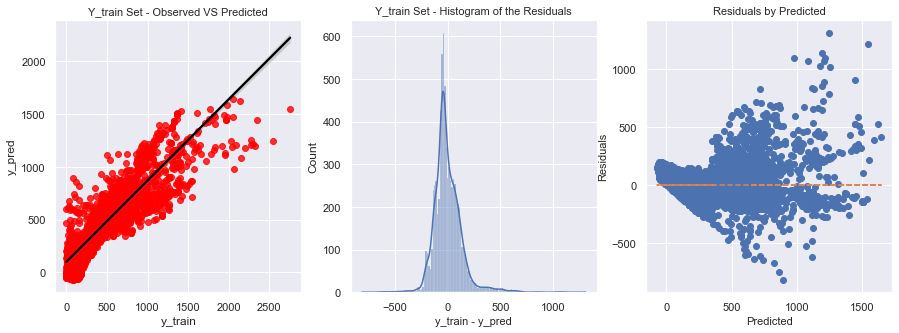

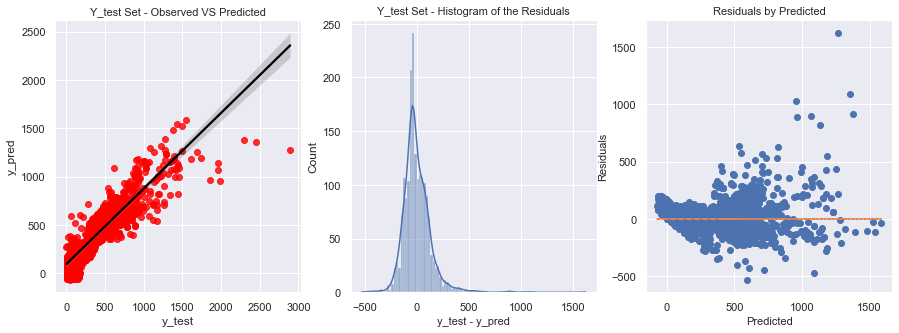

In [ ]:
output_all_cat = my_flex_regression(X_train, y_train, X_test, y_test, LinearRegression(), y_transformer=None)

In [ ]:
output_all_cat["Test"]["Metrics"]

{'MSE': 19031.094042897414,
 'RMSE': 137.95323136083988,
 'MAE': 94.04609499900018,
 'R2': 0.7782388578001901,
 'R2_adj': 0.7755344536270217}

## Further Improvements - Removing Outliers

The highest coefficient corresponds to "Monthly Premium Auto". This feature therefore is the one that contributes the more to "Total Claim Amount"

In [ ]:
sns.boxplot(ca_c_df["Monthly Premium Auto"])

KeyError: 'Monthly Premium Auto'

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Total Claim Amount'>

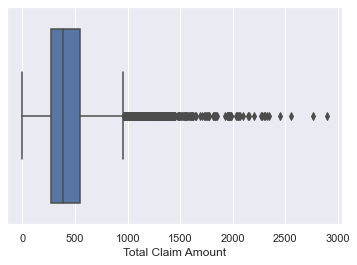

In [ ]:
sns.boxplot(ca_c_df["Total Claim Amount"])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Customer Lifetime Value'>

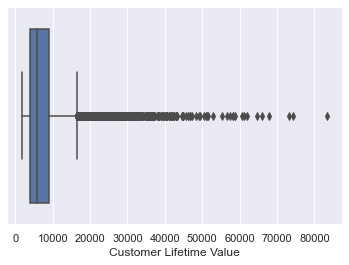

In [ ]:
sns.boxplot(ca_c_df["Customer Lifetime Value"])

In [ ]:
def remove_outliers_one_iteration(df):

    pct_75 = pct(df, 75)
    pct_25 = pct(df, 25)
    upper_bound = pct_75 + 1.5*iqr(df)
    lower_bound = pct_25 - 1.5*iqr(df)
    df = df[(df <= upper_bound) & (df >= lower_bound)]

    return df

def remove_outliers(df, columns_list):

    for column in columns_list:

        outliers = [0]
        pct_75 = pct(df[column], 75)
        upper_bound = pct_75 + 1.5*iqr(df[column])

        while len(outliers) > 0:

            df = df[df[column] < upper_bound]
            pct_75 = pct(df[column], 75)
            upper_bound = pct_75 + 1.5*iqr(df[column])
            outliers = df[column][df[column] > upper_bound]

    return df


In [ ]:
ca_c_no_outliers_df = remove_outliers(ca_c_df, ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Policies', "Total Claim Amount"])

In [ ]:
ca_c_no_outliers_df = ca_c_no_outliers_df.reset_index(drop=True)

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Total Claim Amount'>

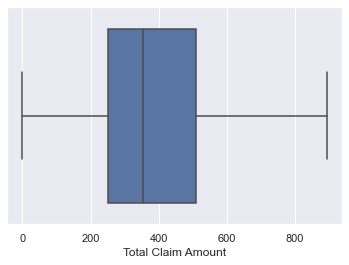

In [ ]:
sns.boxplot(ca_c_no_outliers_df["Total Claim Amount"])

C:\Users\ehern\miniconda3\envs\DA_Environment\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Customer Lifetime Value'>

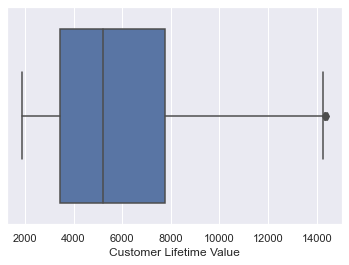

In [ ]:
sns.boxplot(ca_c_no_outliers_df["Customer Lifetime Value"])

In [ ]:
outliers = ca_c_df["Customer Lifetime Value"][ca_c_df["Customer Lifetime Value"] > upper_bound]

NameError: name 'upper_bound' is not defined

In [ ]:
transformed = my_transformations(ca_c_no_outliers_df, test_size=0.2, scaler="minmax")

X_train = pd.concat([transformed["train"][0], transformed["train"][1]], axis=1)
y_train = transformed["train"][2]

X_test = pd.concat([transformed["test"][0], transformed["test"][1]], axis=1)
y_test = transformed["test"][2]

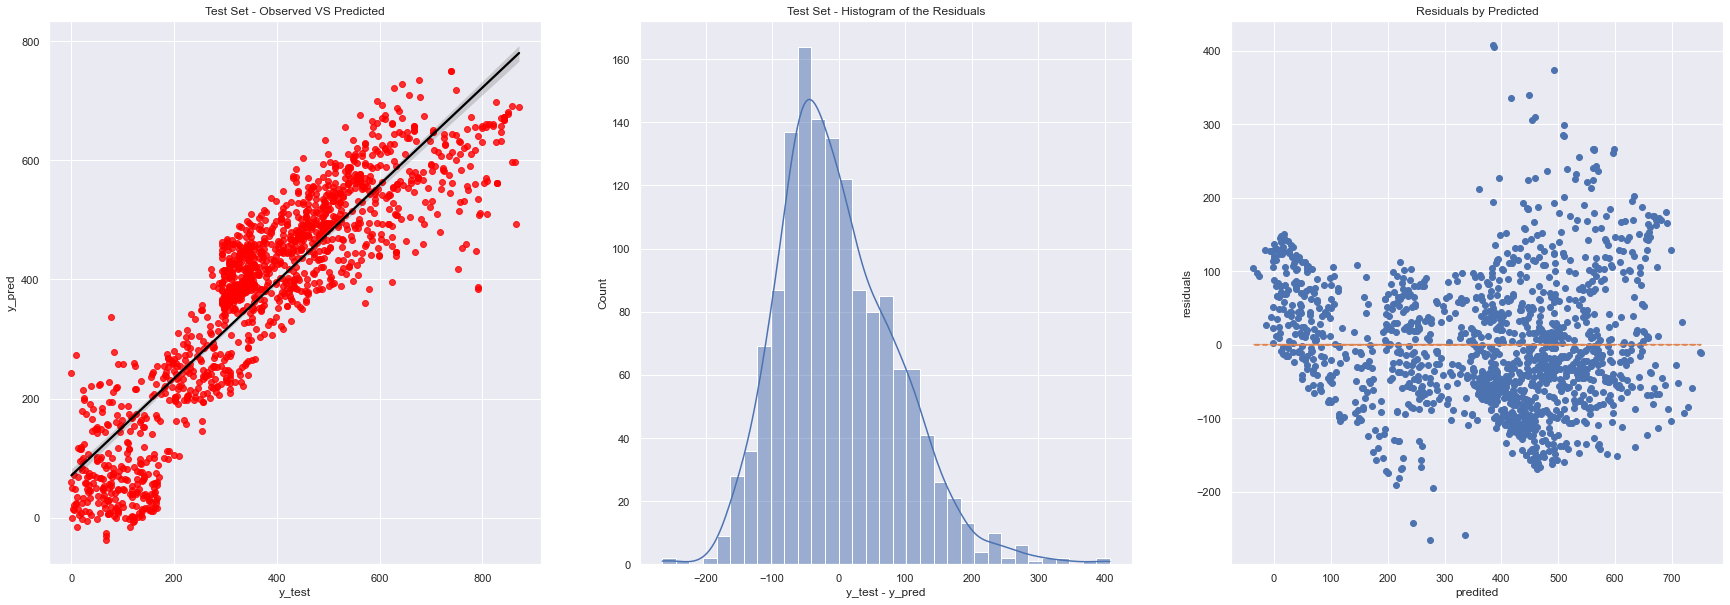

In [ ]:
output_all_cat_no_outliers = my_linear_regression(X_train, y_train, X_test, y_test)

In [ ]:
output_all_cat_no_outliers["Metrics"]

{'MSE': 7894.4106069143845,
 'RMSE': 88.8504958169305,
 'MAE': 70.18143882949357,
 'R2': 0.7978265473698891,
 'R2_adj': 0.7943974570072583}

## Power Transform on Monthly Premium Amount?

array([[<AxesSubplot:title={'center':'Customer Lifetime Value'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Monthly Premium Auto'}>],
       [<AxesSubplot:title={'center':'Months Since Last Claim'}>,
        <AxesSubplot:title={'center':'Months Since Policy Inception'}>,
        <AxesSubplot:title={'center':'Number of Open Complaints'}>],
       [<AxesSubplot:title={'center':'Number of Policies'}>,
        <AxesSubplot:title={'center':'Total Claim Amount'}>,
        <AxesSubplot:>]], dtype=object)

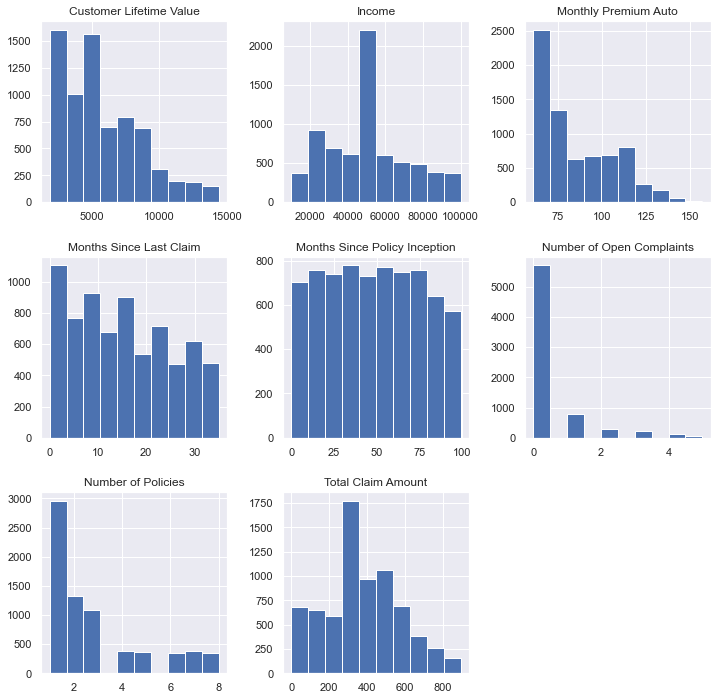

In [ ]:
ca_c_no_outliers_df.hist(figsize=(12,12))

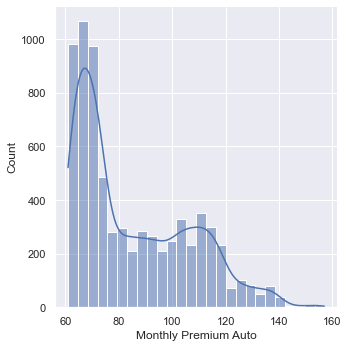

In [ ]:
sns.displot(ca_c_no_outliers_df["Monthly Premium Auto"], kde=True)

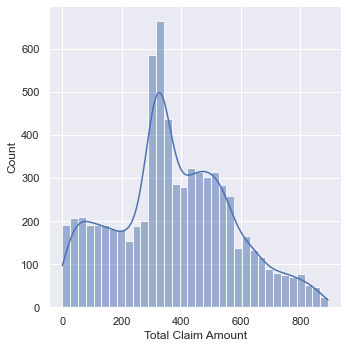

In [ ]:
sns.displot(ca_c_no_outliers_df["Total Claim Amount"], kde=True)

In [ ]:
monthly_premium_auto_transformer = pt.fit(ca_c_no_outliers_df["Monthly Premium Auto"].to_numpy().reshape(-1,1))

monthly_premium_auto_transformed = monthly_premium_auto_transformer.transform(ca_c_no_outliers_df["Monthly Premium Auto"].to_numpy().reshape(-1,1))

print(monthly_premium_auto_transformer.lambdas_)
monthly_premium_auto_transformed = pd.DataFrame(monthly_premium_auto_transformed)

NameError: name 'pt' is not defined

In [ ]:
total_claim_amount_transformer = pt.fit(ca_c_no_outliers_df["Total Claim Amount"].to_numpy().reshape(-1,1))

total_claim_amount_transformed = total_claim_amount_transformer.transform(ca_c_no_outliers_df["Total Claim Amount"].to_numpy().reshape(-1,1))

print(total_claim_amount_transformer.lambdas_)
total_claim_amount_transformed = pd.DataFrame(total_claim_amount_transformed)

[0.76116368]


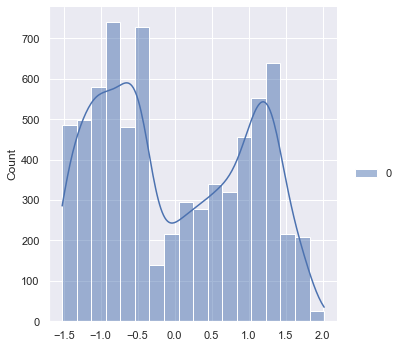

In [ ]:
sns.displot(monthly_premium_auto_transformed, kde=True)

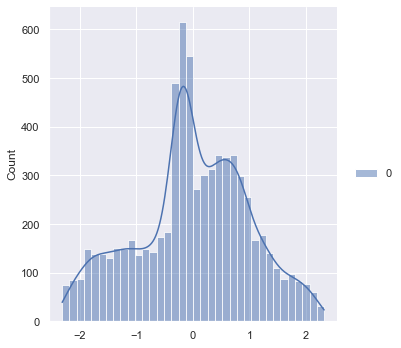

In [ ]:
sns.displot(total_claim_amount_transformed, kde=True)

In [ ]:
ca_c_transf_df = ca_c_no_outliers_df.copy(deep=True)

In [ ]:
ca_c_transf_df["Monthly Premium Auto"] = monthly_premium_auto_transformed
ca_c_transf_df["Total Claim Amount"] = total_claim_amount_transformed

In [ ]:
transformed = my_transformations(ca_c_transf_df, test_size=0.2, scaler="minmax")

X_train = pd.concat([transformed["train"][0], transformed["train"][1]], axis=1)
y_train = transformed["train"][2]

X_test = pd.concat([transformed["test"][0], transformed["test"][1]], axis=1)
y_test = transformed["test"][2]

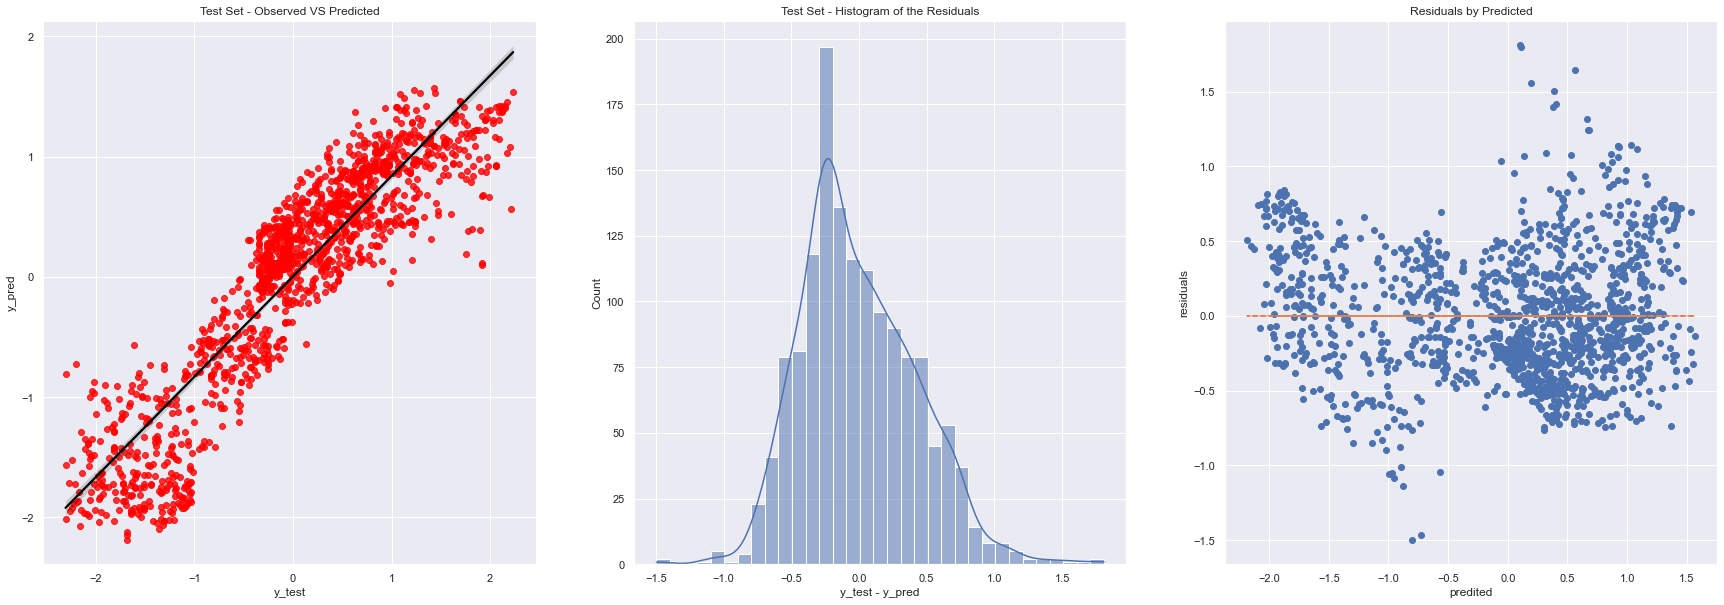

In [ ]:
output_all_cat_no_outliers_transformed = my_linear_regression(X_train, y_train, X_test, y_test)

In [ ]:
output_all_cat_no_outliers_transformed["Metrics"]

{'MSE': 0.1805707068716765,
 'RMSE': 0.4249361209307541,
 'MAE': 0.3424861756231732,
 'R2': 0.8201576987161703,
 'R2_adj': 0.8171073699311442}

### Summary

In [ ]:
print(f'The adjusted R2 for the baseline model (only numerical features) is {round(output_baseline["Metrics"]["R2_adj"],2)}')
print(f'The adjusted R2 for the model baseline + all categorical features is {round(output_all_cat["Metrics"]["R2_adj"],2)}')
print(f'The adjusted R2 for the model baseline + all categorical features + removed outliers is {round(output_all_cat_no_outliers["Metrics"]["R2_adj"],2)}')



KeyError: 'Metrics'

<AxesSubplot:title={'center':'Removed Outliers +  no influential columns dropped'}, xlabel='y_test', ylabel='y_pred'>

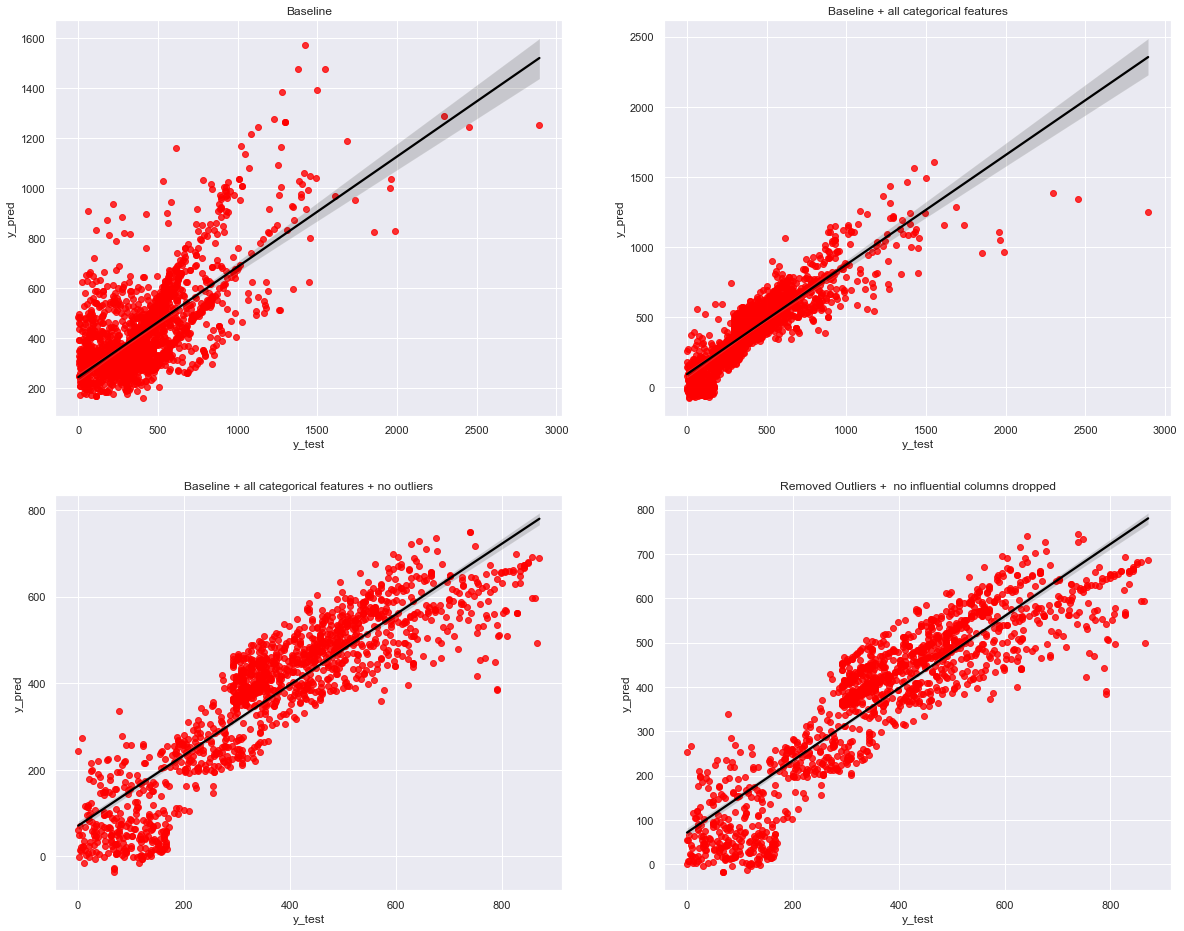

In [ ]:
fig_summary, axs_summary = plt.subplots(2,2,figsize=(20,16))

axs_summary[0,0].set_title("Baseline")
sns.regplot(x="y_test", y="y_pred", data=output_baseline["Result"], scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs_summary[0,0])

axs_summary[0,1].set_title("Baseline + all categorical features")
sns.regplot(x="y_test", y="y_pred", data=output_all_cat["Result"], scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs_summary[0,1])

axs_summary[1,0].set_title("Baseline + all categorical features + no outliers")
sns.regplot(x="y_test", y="y_pred", data=output_all_cat_no_outliers["Result"], scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs_summary[1,0])

axs_summary[1,1].set_title("Removed Outliers +  no influential columns dropped")
sns.regplot(x="y_test", y="y_pred", data=output_red_red_no_outliers["Result"], scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=axs_summary[1,1])


# Different Models Comparison

In [107]:
ca_c_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
ca_c_df = standard_headings(ca_c_df)


In [108]:
drop_columns = ["unnamed:_0", "customer", "effective_to_date", "policy", "vehicle_type"]
bucket_columns = ["vehicle_class"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
clean_columns_zeros = ["income"]
clean_columns_cat = [("response", "No")]
float_columns = list(set(ca_c_df._get_numeric_data().columns).difference(set(drop_columns)))
obj_columns = list(set(ca_c_df.select_dtypes("object").columns).difference(set(drop_columns)))

cleaning_dict = {"Luxury SUV":"Luxury", "Luxury Car":"Luxury"
                 ,np.nan:np.nan
                 }

In [109]:
ca_c_df = (pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
#.pipe(dt_corrector)
.pipe(bucket_series, bucket_columns ,cleaning_dict)
#.drop_duplicates().reset_index(drop=True)
#.pipe(replace_by, clean_columns_NaN)
.pipe(replace_by, clean_columns_zeros, replace_zeros = True)
.pipe(replace_by_cat, clean_columns_cat)
.dropna()
.pipe(standardize_data)
.pipe(float_to_int, float_columns)
.pipe(obj_to_cat, obj_columns)
)

## Function to compare Models

In [110]:
transformed = my_transformations(ca_c_df, test_size=0.2, scaler="standard")

In [111]:
X_train = pd.concat([transformed["train"][0], transformed["train"][1]], axis=1)
y_train = transformed["train"][2].reset_index(drop=True)

X_test = pd.concat([transformed["test"][0], transformed["test"][1]], axis=1)
y_test = transformed["test"][2].reset_index(drop=True)

In [112]:
X_train

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,state_california,state_nevada,state_oregon,...,sales_channel_web,vehicle_class_luxury,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size
0,-0.753097,0.710528,-0.705600,-1.102973,0.211570,-0.419841,-0.824909,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,2.0
1,-0.312679,-1.284657,-0.472575,0.187424,1.429102,-0.419841,2.106809,0,0,1,...,1,0,0,0,0,0.0,1.0,1.0,2.0,2.0
2,0.927371,-0.001503,3.051924,-1.102973,-0.612054,-0.419841,2.525626,0,0,0,...,0,1,0,0,0,0.0,0.0,0.0,3.0,1.0
3,-0.235374,-0.001503,-0.181294,-0.110360,0.677097,-0.419841,0.012724,0,0,0,...,1,0,0,0,0,0.0,1.0,0.0,1.0,2.0
4,0.210824,-0.186650,-0.385191,-0.308882,-0.074908,0.684074,-0.406093,1,0,0,...,0,0,0,0,0,0.0,1.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,3.316874,-0.001503,0.459524,0.286686,-1.650537,-0.419841,-0.406093,0,0,1,...,0,0,0,1,0,0.0,0.0,2.0,2.0,1.0
7303,1.197865,-1.469708,-0.239550,0.584470,-0.576244,-0.419841,-0.406093,0,0,1,...,0,0,0,0,1,1.0,1.0,3.0,1.0,2.0
7304,-0.402554,0.347386,-0.792984,0.882254,0.641287,-0.419841,0.850358,0,0,1,...,0,0,0,0,1,0.0,0.0,1.0,3.0,2.0
7305,0.001596,0.132780,0.226499,0.782992,-0.791103,-0.419841,0.012724,0,0,1,...,0,0,0,1,0,0.0,0.0,0.0,3.0,1.0


In [113]:
X_test

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,state_california,state_nevada,state_oregon,...,sales_channel_web,vehicle_class_luxury,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size
0,-0.852509,-0.001503,-0.559959,-1.003712,0.963575,3.995817,-0.824909,0,0,1,...,0,0,0,0,0,0.0,0.0,1.0,2.0,3.0
1,-0.023112,-0.868555,-0.792984,0.782992,1.500721,-0.419841,-0.406093,0,0,1,...,0,0,0,0,0,0.0,0.0,2.0,2.0,2.0
2,-0.388972,-0.625157,1.187726,1.080776,-1.471488,-0.419841,-0.824909,1,0,0,...,0,0,0,1,0,0.0,1.0,0.0,1.0,2.0
3,0.754845,-0.508511,0.546908,0.782992,0.032521,-0.419841,-0.406093,0,0,1,...,0,0,0,1,0,0.0,0.0,1.0,0.0,2.0
4,-0.582450,2.282747,0.168243,0.088163,0.748716,0.684074,-0.824909,1,0,0,...,0,0,0,0,0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,-0.422783,-0.900922,-0.822112,-1.102973,1.250053,-0.419841,2.525626,0,0,0,...,0,0,0,0,0,0.0,0.0,2.0,0.0,2.0
1823,-0.816675,-1.457791,-0.880368,0.683731,1.715580,-0.419841,-0.824909,0,0,1,...,1,0,0,0,0,1.0,0.0,2.0,0.0,2.0
1824,-0.111687,-0.001503,-0.792984,1.577083,0.211570,0.684074,-0.406093,1,0,0,...,0,0,0,0,0,0.0,0.0,0.0,2.0,2.0
1825,-0.415848,0.140360,-0.851240,-0.209621,-0.253957,-0.419841,0.850358,0,0,0,...,0,0,0,0,0,0.0,0.0,3.0,2.0,2.0


In [114]:
y_train

0       481
1        13
2       962
3       417
4       118
       ... 
7302    691
7303    574
7304    393
7305    484
7306    523
Name: total_claim_amount, Length: 7307, dtype: int32

In [115]:
y_test

0       369
1       316
2       898
3       806
4       459
       ... 
1822    100
1823    352
1824    393
1825    278
1826    414
Name: total_claim_amount, Length: 1827, dtype: int32

In [116]:
def model_compare(df, list_models):

    output = {}

    transformed = my_transformations(df, test_size=0.2, scaler="standard")

    X_train = pd.concat([transformed["train"][0], transformed["train"][1]], axis=1)
    y_train = transformed["train"][2]

    X_test = pd.concat([transformed["test"][0], transformed["test"][1]], axis=1)
    y_test = transformed["test"][2]
    
    for model in list_models:
        
        output[str(model)[:str(model).index("(")]] = my_flex_regression(X_train, y_train, X_test, y_test, model, y_transformer=None, verbose = False, plot = False)
    
    return output



In [117]:
results = model_compare(ca_c_df, [LinearRegression(), Lasso(alpha=10), Ridge(alpha=1),KNeighborsRegressor(n_neighbors=15)])

In [118]:
results["LinearRegression"]["Metrics"]

,train,test
MSE,19408.904184,19031.094043
RMSE,139.315843,137.953231
MAE,95.756614,94.046095
R2,0.769028,0.778239
R2_adj,0.768330,0.775534


In [119]:
results["Lasso"]["Metrics"]

,train,test
MSE,23081.860872,21830.916279
RMSE,151.927156,147.752889
MAE,103.258897,99.679690
R2,0.725319,0.745614
R2_adj,0.724489,0.742511


In [120]:
results["Ridge"]["Metrics"]

,train,test
MSE,19408.959655,19029.702810
RMSE,139.316042,137.948189
MAE,95.724919,94.006095
R2,0.769027,0.778255
R2_adj,0.768330,0.775551


In [121]:
results["KNeighborsRegressor"]["Metrics"]

,train,test
MSE,24982.399510,28473.818427
RMSE,158.058216,168.741869
MAE,108.505543,113.693633
R2,0.702702,0.668207
R2_adj,0.701804,0.664161


# Feature Selection

In [39]:
ca_c_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
ca_c_df = standard_headings(ca_c_df)

In [40]:

drop_columns = ["unnamed:_0", "customer", "effective_to_date", "policy", "vehicle_type"]
bucket_columns = ["vehicle_class"]
# clean_columns_NaN = ["customer_lifetime_value", "income", "monthly_premium_auto", "number_of_open_complaints", "total_claim_amount"]
clean_columns_zeros = ["income"]
clean_columns_cat = [("response", "No")]
float_columns = list(set(ca_c_df._get_numeric_data().columns).difference(set(drop_columns)))
obj_columns = list(set(ca_c_df.select_dtypes("object").columns).difference(set(drop_columns)))

cleaning_dict = {"Luxury SUV":"Luxury", "Luxury Car":"Luxury"
                 ,np.nan:np.nan
                 }

In [41]:
ca_c_df = (pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round2.csv")
.pipe(standard_headings)
.drop(drop_columns, axis=1)
#.pipe(dt_corrector)
.pipe(bucket_series, bucket_columns ,cleaning_dict)
#.drop_duplicates().reset_index(drop=True)
#.pipe(replace_by, clean_columns_NaN)
.pipe(replace_by, clean_columns_zeros, replace_zeros = True)
.pipe(replace_by_cat, clean_columns_cat)
.dropna()
.pipe(standardize_data)
.pipe(float_to_int, float_columns)
.pipe(obj_to_cat, obj_columns)
)

In [48]:
transformed = my_transformations(ca_c_df, test_size=0.2, scaler=None)

## Variance threshold method

In [49]:
X_train_num = transformed["train"][0].reset_index(drop=True)
X_train_cat = transformed["train"][1].reset_index(drop=True)
X_test_num = transformed["test"][0].reset_index(drop=True)
X_test_cat = transformed["test"][1].reset_index(drop=True)

In [50]:
X_train_num

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,2799,65351,69,4,54,0,1
1,5847,23496,77,17,88,0,8
2,14429,50414,198,4,31,0,9
3,6382,50414,87,14,67,0,3
4,9470,46530,80,12,46,1,2
...,...,...,...,...,...,...,...
7302,30966,50414,109,18,2,0,2
7303,16301,19614,85,21,32,0,2
7304,5225,57733,66,24,66,0,5
7305,8022,53231,101,23,26,0,3


In [51]:
temp_train = X_train_num[["number_of_open_complaints", "number_of_policies"]]
temp_train = obj_to_cat(temp_train, ["number_of_open_complaints", "number_of_policies"])
X_train_cat = pd.concat([X_train_cat, temp_train], axis = 1)
X_train_num = X_train_num.drop(columns=["number_of_open_complaints", "number_of_policies"])
X_train_cat


C:\Users\ehern\AppData\Local\Temp/ipykernel_7208/810249551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype("category")


,state_california,state_nevada,state_oregon,state_washington,employmentstatus_employed,employmentstatus_medical leave,employmentstatus_retired,employmentstatus_unemployed,gender_m,location_code_suburban,...,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size,number_of_open_complaints,number_of_policies
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0.0,0.0,0.0,1.0,2.0,0,1
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0.0,1.0,1.0,2.0,2.0,0,8
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0.0,0.0,0.0,3.0,1.0,0,9
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0.0,1.0,0.0,1.0,2.0,0,3
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0.0,1.0,1.0,0.0,2.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,0,0,1,0,0,0,0,1,1,1,...,0,1,0,0.0,0.0,2.0,2.0,1.0,0,2
7303,0,0,1,0,0,0,1,0,0,1,...,0,0,1,1.0,1.0,3.0,1.0,2.0,0,2
7304,0,0,1,0,1,0,0,0,1,1,...,0,0,1,0.0,0.0,1.0,3.0,2.0,0,5
7305,0,0,1,0,1,0,0,0,1,1,...,0,1,0,0.0,0.0,0.0,3.0,1.0,0,3


In [52]:
temp_test = X_test_num[["number_of_open_complaints", "number_of_policies"]]
temp_test = obj_to_cat(temp_test, ["number_of_open_complaints", "number_of_policies"])
X_test_cat = pd.concat([X_test_cat, temp_test], axis = 1)
X_test_num = X_test_num.drop(columns=["number_of_open_complaints", "number_of_policies"])
X_test_cat

C:\Users\ehern\AppData\Local\Temp/ipykernel_7208/810249551.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype("category")


,state_california,state_nevada,state_oregon,state_washington,employmentstatus_employed,employmentstatus_medical leave,employmentstatus_retired,employmentstatus_unemployed,gender_m,location_code_suburban,...,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size,number_of_open_complaints,number_of_policies
0,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0.0,0.0,1.0,2.0,3.0,4,1
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0.0,0.0,2.0,2.0,2.0,0,2
2,1,0,0,0,1,0,0,0,1,1,...,0,1,0,0.0,1.0,0.0,1.0,2.0,0,1
3,0,0,1,0,1,0,0,0,1,1,...,0,1,0,0.0,0.0,1.0,0.0,2.0,0,2
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0.0,1.0,0.0,0.0,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0.0,0.0,2.0,0.0,2.0,0,9
1823,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1.0,0.0,2.0,0.0,2.0,0,1
1824,1,0,0,0,0,0,0,1,1,1,...,0,0,0,0.0,0.0,0.0,2.0,2.0,1,2
1825,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0.0,0.0,3.0,2.0,2.0,0,5


In [53]:
selector = VarianceThreshold(threshold=200)

In [54]:
selector.fit(X_train_num)

VarianceThreshold(threshold=200)

In [55]:
kept_features_indexes = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train_num.iloc[:,kept_features_indexes].columns)
kept_features

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_policy_inception']

In [56]:
X_train_num = selector.transform(X_train_num)
X_test_num  = selector.transform(X_test_num)

X_train_num = pd.DataFrame(X_train_num, columns=kept_features)
X_test_num  = pd.DataFrame(X_test_num, columns=kept_features)

print("Final number of numerical columns: ",X_train_num.shape)
print()
X_train_num

Final number of numerical columns:  (7307, 4)



,customer_lifetime_value,income,monthly_premium_auto,months_since_policy_inception
0,2799,65351,69,54
1,5847,23496,77,88
2,14429,50414,198,31
3,6382,50414,87,67
4,9470,46530,80,46
...,...,...,...,...
7302,30966,50414,109,2
7303,16301,19614,85,32
7304,5225,57733,66,66
7305,8022,53231,101,26


## Recursive feature elimination

In [57]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
y_train = transformed["train"][2].reset_index(drop=True)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)
y_test = transformed["test"][2].reset_index(drop=True)

In [58]:
X_train

,customer_lifetime_value,income,monthly_premium_auto,months_since_policy_inception,state_california,state_nevada,state_oregon,state_washington,employmentstatus_employed,employmentstatus_medical leave,...,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size,number_of_open_complaints,number_of_policies
0,2799,65351,69,54,0,0,0,0,1,0,...,0,0,0,0.0,0.0,0.0,1.0,2.0,0,1
1,5847,23496,77,88,0,0,1,0,0,1,...,0,0,0,0.0,1.0,1.0,2.0,2.0,0,8
2,14429,50414,198,31,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,3.0,1.0,0,9
3,6382,50414,87,67,0,0,0,0,0,0,...,0,0,0,0.0,1.0,0.0,1.0,2.0,0,3
4,9470,46530,80,46,1,0,0,0,1,0,...,0,0,0,0.0,1.0,1.0,0.0,2.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7302,30966,50414,109,2,0,0,1,0,0,0,...,0,1,0,0.0,0.0,2.0,2.0,1.0,0,2
7303,16301,19614,85,32,0,0,1,0,0,0,...,0,0,1,1.0,1.0,3.0,1.0,2.0,0,2
7304,5225,57733,66,66,0,0,1,0,1,0,...,0,0,1,0.0,0.0,1.0,3.0,2.0,0,5
7305,8022,53231,101,26,0,0,1,0,1,0,...,0,1,0,0.0,0.0,0.0,3.0,1.0,0,3


In [59]:
X_test

,customer_lifetime_value,income,monthly_premium_auto,months_since_policy_inception,state_california,state_nevada,state_oregon,state_washington,employmentstatus_employed,employmentstatus_medical leave,...,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car,response,coverage,education,renew_offer_type,vehicle_size,number_of_open_complaints,number_of_policies
0,2111,50414,74,75,0,0,1,0,0,0,...,0,0,0,0.0,0.0,1.0,2.0,3.0,4,1
1,7851,32225,66,90,0,0,1,0,1,0,...,0,0,0,0.0,0.0,2.0,2.0,2.0,0,2
2,5319,37331,134,7,1,0,0,0,1,0,...,0,1,0,0.0,1.0,0.0,1.0,2.0,0,1
3,13235,39778,112,49,0,0,1,0,1,0,...,0,1,0,0.0,0.0,1.0,0.0,2.0,0,2
4,3980,98333,99,69,1,0,0,0,1,0,...,0,0,0,0.0,1.0,0.0,0.0,2.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,5085,31546,65,83,0,0,0,0,1,0,...,0,0,0,0.0,0.0,2.0,0.0,2.0,0,9
1823,2359,19864,63,96,0,0,1,0,0,0,...,0,0,0,1.0,0.0,2.0,0.0,2.0,0,1
1824,7238,50414,66,54,1,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,2.0,2.0,1,2
1825,5133,53390,64,41,0,0,0,1,1,0,...,0,0,0,0.0,0.0,3.0,2.0,2.0,0,5


In [60]:
y_train

0       481
1        13
2       962
3       417
4       118
       ... 
7302    691
7303    574
7304    393
7305    484
7306    523
Name: total_claim_amount, Length: 7307, dtype: int32

In [66]:
selector = RFE(LinearRegression(), n_features_to_select= 3, step = 1, verbose = 1)

In [67]:
selector.fit(X_train_num, y_train)

Fitting estimator with 4 features.


RFE(estimator=LinearRegression(), n_features_to_select=3, verbose=1)

In [68]:
kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)
kept_features

['income', 'monthly_premium_auto', 'months_since_policy_inception']

In [ ]:
kept_features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
kept_features = list(X_train.iloc[:,kept_features].columns)

X_train = selector.transform(X_train)
X_test  = selector.transform(X_test)

X_train = pd.DataFrame(X_train, columns=kept_features)
X_test  = pd.DataFrame(X_test, columns=kept_features)

print("Final selected features: ")
display(X_train)


Final selected features: 


,employmentstatus_retired,employmentstatus_unemployed,gender_m,location_code_suburban,location_code_urban,marital_status_single,vehicle_class_luxury,vehicle_class_sports car
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7302,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
7303,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7304,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7305,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
